# **Reinforcement Learning Stock Trading Project**

- Zhenning Li 
- zhenning.li@student-cs.fr

# Overall Summary

- Try DQL, use the single close price as training dataset and train with all tickers’ information
- Use 3 factors and train with all tickers’ information
- Use 6 other factors and train with all tickers’ information
- Use 6 other factors  and split all tickers into 3 groups based on KMeans

(Currently we mainly use companies that are in DJI and Nasdaq)

In each trial, we will train with 15 largest companies using historical information and make predictions on later periods and see if a stable investment return can be made (average return of buying all tickers of same amount of capital), and make visualizations when necessary.

## Package preparation

In [ ]:
# for getting stock information
!pip install yfinance --quiet
!pip install yql --quiet
!pip install quandl --quiet
# for getting ticker names
!pip install yahoo_fin --quiet

     |████████████████████████████████| 6.4 MB 19.0 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 81 kB 7.9 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 138 kB 72.3 MB/s 
     |████████████████████████████████| 111 kB 73.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 r

In [ ]:
# system package
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from collections import Counter
from tqdm import tqdm

# for getting stock information
import pandas_datareader as pdr
import pandas_datareader.data as web
import quandl
import quandl as quandl
import yfinance as yf

# data processing
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

np.random.seed(19)
np.set_printoptions(suppress=True)
random.seed(19)

import warnings
warnings.filterwarnings('ignore')

quandl.ApiConfig.api_key = 'gSPqUVhNJ8GdaRVVaMow'
sns.set()

## Stock Data Loading & Preparation

In [ ]:
import pandas as pd
from yahoo_fin import stock_info as si

In [ ]:
ticker_nasdaq = pd.DataFrame(si.tickers_nasdaq())[0].to_list()
ticker_dow = pd.DataFrame(si.tickers_dow())[0].to_list()
# ticker_sp500 = pd.DataFrame(si.tickers_sp500())
# ticker_other = pd.DataFrame(si.tickers_other())

tickers = ticker_dow.copy() # But one problem here is if we use nasdaq, 
# it's very very easy to buy those small companies and the liquidity and market manipulation is really a problem!
# So, prefer to use DOW instead, where there are only 30 tickers available but all of them are great big companies.

Remember to filter out those newly listed companies! They very likely don't have data!

## Other technical indicators and factors

In [ ]:
def get_company_stock_data(company_name, start_date, end_date):
    df = yf.download(tickers = company_name,
                     start = start_date,
                     end = end_date,
                     group_by = 'ticker')
    return df

def get_nasdaq_index(start_date, end_date):
    ndq = quandl.get("NASDAQOMX/COMP-NASDAQ", 
                    trim_start = start_date, 
                    trim_end = end_date)
    ndq = ndq.reset_index()
    return ndq

def get_gs10_data(start_date, end_date):
    return pdr.get_data_fred('GS10', start=start_date, end=end_date)

def get_DJI(start_date, end_date):
    return  yf.download(tickers = '^DJI',
                     start = start_date,
                     end = end_date,
                     group_by = 'ticker')

In [ ]:
# Add a high-low colume to df
def add_difference(df):
    df['difference'] = df.High - df.Low
    return df

# add Nasdaq index of the same period
def add_nasdaq(df, start_date, end_date):
    nasdaq_data = get_nasdaq_index(start_date, end_date)
    df['nasdaq_index'] = list(nasdaq_data['Index Value'][:-1])
    df['nasdaq_dividend_market_value'] = list(nasdaq_data['Dividend Market Value'][:-1])
    return df

# add dji index
def add_dji(df, start_date, end_date):
    df['dji_adj_close'] = get_DJI(start_date, end_date)['Adj Close']
    df['dji_volume'] = get_DJI(start_date, end_date)['Volume']
    return df

In [ ]:
# add stupid Moving Average lines of 5, 10, and 30 days
def add_ma_5_10_30(df, date_colume_name, stock_close_colume_name):
    df.sort_values(date_colume_name, inplace = True)
    ma_list = [5, 10, 30]

    for ma in ma_list:
        df['ma_' + str(ma)] = df[stock_close_colume_name].rolling(ma).mean()

    for ma in ma_list:
        df.loc[:ma, 'ma_' + str(ma)] = df[stock_close_colume_name][:ma+1]
    return df

In [ ]:
# add rsi index, use 14 days as default periods
def add_rsi(df, periods = 14, ema = True):
    """
    Returns a pd.Series with the relative strength index.
    """
    close_delta = df['Close'].diff()

    # Make two series: one for lower closes and one for higher closes
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    
    if ema == True:
	    # Use exponential moving average
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        # Use simple moving average
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()
        
    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))

    # 现在将前面14个NaN值填充为第一个实际的值
    rsi[: periods] = [rsi[periods] for i in range(periods)]

    # 加入df中
    df['rsi'] = rsi

    return df

In [ ]:
# add macd index, only calculate EMA1 and difference
def add_macd(df):
    EMA1 = df.Close.ewm(span=12, adjust=False).mean()
    EMA2 = df.Close.ewm(span=26, adjust=False).mean()
    DIF = EMA1 - EMA2
    DEA = DIF.ewm(9, adjust=False).mean()
    BAR = 2 * (DIF - DEA)

    df['macd_Bar'] = BAR
    df['macd_EMA1'] = EMA1
    return df

In [ ]:
def load_close(ticker, start_date, end_date):
    df = yf.download(tickers=ticker, start=start_date, end=end_date,group_by='ticker')
    return df.Close.values.tolist(), df

In the following function, the output is in a flattened format (numpy.array), which is convenient for training (using dense).

In [ ]:
train_start_date, train_end_date = "2020-01-01", "2020-12-31"
test_start_date, test_end_date = "2020-01-01", "2020-12-31"

def prepare_stock_data(ticker, 
                       start_date=train_start_date, 
                       end_date=train_end_date, 
                       close_price_normalize=False,
                       factors_1=False, # default set to 3 factors, more reasonable
                       factors_3=True, 
                       factors_6=False, 
                       flatten=True,
                       for_showing_in_report=False):
    
    print(f'preparing data for {ticker}...')
    stock_data = get_company_stock_data(ticker, 
                                        start_date=train_start_date, 
                                        end_date=train_end_date)

    # 添加difference
    stock_data = add_difference(stock_data)

    # 添加nasdaq
    stock_data = add_nasdaq(stock_data, 
                            start_date=train_start_date, 
                            end_date=train_end_date)

    # 添加dji
    stock_data = add_dji(stock_data, 
                         train_start_date, 
                         train_end_date)

    stock_data = stock_data.reset_index()

    # 添加5 10 30日线
    stock_data = add_ma_5_10_30(stock_data, date_colume_name='Date', stock_close_colume_name='Close')

    # 添加rsi指标
    stock_data = add_rsi(stock_data)

    # 删除date列
    stock_data = stock_data.drop(['Date'], axis=1)
    colume_names = list(stock_data.columns)

    # 直接在这里进行normalize！但是
    if close_price_normalize:
        # print('begin all normalizing')
        x = stock_data.values #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        stock_data_temp = pd.DataFrame(x_scaled)
        
        # 恢复normalize之后的index和列名
        stock_data_temp.columns = colume_names
        stock_data_temp.index = stock_data.index
        stock_data = stock_data_temp

    else:
        # print('begin normalizing')
        x = stock_data.drop(['Close'], axis=1).values  #returns a numpy array
        min_max_scaler = preprocessing.MinMaxScaler()
        x_scaled = min_max_scaler.fit_transform(x)
        stock_data_temp = pd.DataFrame(x_scaled)

        # 恢复normalize之后的index和列名
        colume_names.remove('Close') # 注意，remove之后返回None！需要调用之前的list！
        stock_data_temp.columns = colume_names
        stock_data_temp.index = stock_data.index
        stock_data = stock_data[['Close']].join(stock_data_temp)

    # one factor model
    if factors_1:
        temp = stock_data[['Close']]
        if flatten:
            return np.array(temp).flatten('F'), len(stock_data)
        return temp, len(stock_data)
    
    # three factor model
    if factors_3:
        temp = stock_data[['Close', 'Volume', 'rsi']]
        if flatten:
            return np.array(temp).flatten('F'), len(stock_data)
        return temp, len(stock_data)

    # six factor model
    if factors_6:
        temp = stock_data[['Close', 'Volume', 'difference', 'nasdaq_index', 'ma_5', 'rsi']]
        if flatten:
            return np.array(temp).flatten('F'), len(stock_data)
        return temp, len(stock_data)

    # only for showing the result in the report. In training, this must be False
    if for_showing_in_report:
        return stock_data

In [ ]:
# example
prepare_stock_data('AAPL',
                       factors_1=False, # default set to 3 factors, more reasonable
                       factors_3=True, 
                       factors_6=False, 
                       flatten=True,
                       for_showing_in_report=False)

## Build training and testing dict

In [ ]:
# run this function, and you get the data in dictionary that can be directly used in training the model.
def building_data(tickers, 
                  train_start_date, 
                  train_end_date, 
                  test_start_date, 
                  test_end_date,
                  factors_1,
                  factors_3, 
                  factors_6, 
                  flatten,
                  train_size = 15,
                  test_size = 10):
    
    # train_start_date, train_end_date = "2020-01-01", "2020-12-31"
    # test_start_date, test_end_date = "2020-01-01", "2020-12-31"

    avalaible_tickers = tickers.copy()
    try:
        avalaible_tickers.remove('DOW') # this one is always problematic
    except:
        pass
    else:
        pass

    print("Building training data...")
    train_size = train_size
    all_train_data = {}
    while len(all_train_data) < train_size:
        ticker = np.random.choice(avalaible_tickers)
        
        # DOW is not available
        if ticker=='DOW':
            avalaible_tickers.remove(ticker)
            pass

        ticker_all, len_dimension = prepare_stock_data(ticker, 
                                                    start_date=train_start_date, 
                                                    end_date=train_end_date,
                                                    factors_1=factors_1,
                                                    factors_3=factors_3, 
                                                    factors_6=factors_6, 
                                                    flatten=flatten)
        if len_dimension > 0:
            all_train_data[ticker] = ticker_all # it's an array in flatten format
        print(ticker)
        avalaible_tickers.remove(ticker)

    print("Building testing data...") # use same period or different period
    test_size = test_size
    all_test_data = {}
    while len(all_test_data) < test_size:
        ticker = np.random.choice(avalaible_tickers)
        
        # DOW is not available
        if ticker=='DOW':
            avalaible_tickers.remove(ticker)
            pass

        ticker_all, len_dimension = prepare_stock_data(ticker, 
                                                    start_date=test_start_date, 
                                                    end_date=test_end_date,
                                                    factors_1=factors_1,
                                                    factors_3=factors_3, 
                                                    factors_6=factors_6, 
                                                    flatten=flatten)
        if len_dimension > 0:
            all_test_data[ticker] = ticker_all
        print(ticker)
        avalaible_tickers.remove(ticker)

    return all_train_data, all_test_data

# Agent

In [ ]:
from collections import deque # used for storing bought stocks' cost price, following first in first out principle
import random

class Agent:
    def __init__(self, state_size, 
                 window_size, 
                 trend_data, 
                 skip, 
                 batch_size, 
                 drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],
                 GD_learning_rate = 1e-5,
                 gamma = 0.95,
                 epsilon = 0.5,
                 epsilon_min = 0.01,
                 epsilon_decay = 0.9997,
                 no_of_factors = 3):
        
        self.state_size = state_size

        # states are only useful when in window
        self.window_size = window_size
        self.half_window = window_size / 2
        self.trend_data = trend_data

        # skip is for simulating daily data or weekly data of data of any days. skip=1 is daily, =5 is weekly
        self.skip = skip

        # only 3 actions here: 0 is not doing anything, 1 is buying with all money, 2 is selling all we have
        self.action_size = 3
        self.batch_size = batch_size

        # deque, first in first out
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        # hyper parameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.drop_out_rate = drop_out_rate

        # factor_no, used in splitting trend data (only using first part data as close price)
        self.no_of_factors = no_of_factors

        # tf settings
        tf.compat.v1.reset_default_graph()

        self.sess = tf.compat.v1.InteractiveSession()
        tf.compat.v1.disable_eager_execution()

        # X variable initiation
        self.X = tf.compat.v1.placeholder(tf.float32, [None, self.state_size])

        # Y variable initiation: prediction that makes the reward maximal
        self.Y = tf.compat.v1.placeholder(tf.float32, [None, self.action_size])

        # neural network
        ########################################################################
        layer1 = tf.compat.v1.layers.dense(self.X, 64, activation = tf.nn.relu)
        layer2 = tf.compat.v1.layers.dense(layer1, 256, activation = tf.nn.relu)

        layer_dropout = tf.keras.layers.Dropout(self.drop_out_rate[0])
        outputs = layer_dropout(layer2, training=True)

        layer3 = tf.compat.v1.layers.dense(outputs, 1024, activation = tf.nn.relu)

        layer_dropout_2 = tf.keras.layers.Dropout(self.drop_out_rate[1])
        outputs_2 = layer_dropout_2(layer3, training=True)

        layer4 = tf.compat.v1.layers.dense(outputs_2, 256, activation = tf.nn.relu)

        layer_dropout_3 = tf.keras.layers.Dropout(self.drop_out_rate[2])
        outputs_3 = layer_dropout_3(layer4, training=True)

        layer5 = tf.compat.v1.layers.dense(outputs_3, 64, activation = tf.nn.relu)

        layer_dropout_4 = tf.keras.layers.Dropout(self.drop_out_rate[3])
        outputs_4 = layer_dropout_4(layer5, training=True)

        layer6 = tf.compat.v1.layers.dense(outputs_4, 16, activation = tf.nn.relu)

        layer_dropout_5 = tf.keras.layers.Dropout(self.drop_out_rate[4])
        outputs_5 = layer_dropout_5(layer6, training=True)

        # logits is the prediction
        self.logits = tf.compat.v1.layers.dense(outputs_5, self.action_size)
        ########################################################################

        # Here cost is the loss, which is calculated by action->reward minus logits value.
        # We want logits to be close to self.Y. DQL has to move towards the maximal rewars.
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.GradientDescentOptimizer(GD_learning_rate).minimize(
            self.cost
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())


    # Only allow agents to take actions it can take: get_action() cannot choose 1 if the agent doesn't have enough money
    def argmax(self, vals):
        top = float("-inf")
        ties = []
        for i in range(len(vals)):
            if vals[i] > top:
                top = vals[i]
                ties = []
            if vals[i] == top or np.isnan(vals[i]):
                ties.append(i)
        return np.random.choice(ties)


    def get_action(self, state, available_actions, train=True): # Here the state has format like np.array([res_close, res_volume...])
        # epsilon-greedy method
        if not train or random.random() <= self.epsilon or not train:
            return np.random.choice(available_actions)
        
        # choose largest Q value after updation
        action_values = self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        return available_actions[self.argmax([action_values[action] for action in available_actions])]
    

    def get_state(self, t, trend): # Here we plainly add factors (flattened format) in one list, because we are using Dense and Dense can link elements together
        # We set a window of data here, make sure every fed data has same window size length and dimension
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = trend[d : t + 1] if d >= 0 else -d * [trend[0]] + trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])


    def replay(self, batch_size):
        # Train the data using mini_batch method
        mini_batch = []
        l = len(self.memory) # memory is deque, first in first out

        # choose a part of memory
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i]) # self.memory has format (state, action, invest, next_state, starting_money < initial_money)

        replay_size = len(mini_batch)

        X = np.empty((replay_size, self.state_size)) # state size is window size
        Y = np.empty((replay_size, self.action_size))
        
        # mini_batch records format like this
        # (state, action, reward(invest), next_state, and if successful judgement（starting_money < initial_money）)

        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])

        # Get Q value based on actions got from states
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})

        # Network
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            # target is Q table
            # self.logits = tf.layers.dense(feed, self.action_size)

            target = Q[i]
            target[action] = reward

            # Update Q table when having positive return
            if not done:
                # Original Q value plus new Q value to make Q_new maximal
                target[action] += self.gamma * np.amax(Q_new[i])

            X[i] = state
            # Here Y is the reward got from simulation
            Y[i] = target

        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    

    # This is paper trading
    def operate(self, initial_money, trend, print_out=True):
        # operate这里的trend是全trend！是时间长度*factor数量

        starting_money = initial_money or 2*trend[0]
        current_money = starting_money
        states_sell = []
        states_buy = []
        inventory = []

        # Here we used differencing to diminish the effect of absolute number
        lag1 = np.array(trend)[1:] - np.array(trend)[:-1]
        lag1 = [0] + list(lag1)

        # state at time 0
        state = self.get_state(0, lag1)

        for t in range(0, int(len(trend)/self.no_of_factors) - 1, self.skip):
            # judge what actions we can have in action pools
            available_actions = [0]

            if current_money >= trend[t] and t < (len(trend)/self.no_of_factors - self.half_window):
                available_actions.append(1)
            if len(inventory) > 0:
                available_actions.append(2)

            action = self.get_action(state, available_actions, train=False)
            next_state = self.get_state(t + 1, lag1)
            

            if action == 1 and initial_money >= trend[t] and t < (len(trend)/self.no_of_factors - self.half_window):
                inventory.append(trend[t])
                current_money -= trend[t]
                states_buy.append(t)
                
                if print_out:
                    print('        day %d: buy 1 unit at price %f, total balance %f'% (t, trend[t], current_money))
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                current_money += trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0

                if print_out:
                    print(
                        '        day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                        % (t, close[t], invest, current_money)
                    )
            
            state = next_state

        invest = ((current_money - starting_money) / starting_money) * 100
        total_gains = current_money - starting_money
        return states_buy, states_sell, total_gains, invest
        

    def train(self, iterations, checkpoint, initial_money):
        # Begin to run episodes, every state updation only depends on the next one
        for i in range(iterations):
            total_profit = 0
            inventory = []

            # print(len(self.trend_data))
            ticker = list(self.trend_data.keys())[i%(len(self.trend_data))]
            trend = self.trend_data[ticker][:252] # 这里要指明252！！！！！！！！！！！！不这样写就崩掉了。。当然如果是多年的再改！

            lag1 = np.array(trend)[1:] - np.array(trend)[:-1]
            lag1 = [0] + list(lag1) # keep length same as before and other factors

            state = self.get_state(0, lag1)
            starting_money = initial_money or 2*trend[0]
            current_money = starting_money
            
            # use data
            for t in range(0, len(trend) - 1, self.skip): # 这里trend长度只有10！如果train是10个ticker的话！
                # make decision on current state
                available_actions = [0]

                if current_money >= trend[t] and t < (len(trend) - self.half_window):
                    available_actions.append(1)
                if len(inventory) > 0:
                    available_actions.append(2)
                
                action = self.get_action(state, available_actions)
                next_state = self.get_state(t + 1, lag1)
                
                # buying behavior will affect inventory and current money balance, but not affecting volume
                if action == 1:
                    inventory.append(trend[t])
                    current_money -= trend[t]
                
                # selling behavior will affect balance and result in a return (related to reward)
                elif action == 2:
                    # buying price is the price when bought, first in first out
                    bought_price = inventory.pop(0)
                    total_profit += (trend[t] - bought_price)
                    current_money += trend[t]
                    
                # Reward here is calculated as one-step return, it's too simple in reality but here we keep it
                # Take into consideration of accumulated return
                invest = ((current_money - starting_money) / starting_money)
 
                self.memory.append((state, action, invest, 
                                    next_state, current_money < starting_money))
                
                # states update
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)

            if (i+1) % checkpoint == 0:
                print(f"ticker: {ticker}, epoch: {i + 1}, total rewards: {total_profit:.2f}, "\
                      f"return: {(100*total_profit/starting_money):.4f}%, "\
                      f"cost: {cost:.2f}, total money: {current_money:.2f}," \
                      f"initial money: {starting_money:.2f}, epsion: {self.epsilon:.2f}")

In [ ]:
# calculate the overall profit if we spent same amount of money on all companies' stocks (base money=100)
def calculate_final_total_money(initial_money, stats, print_or_no=True):
    final_return = 0
    divisor = len(stats.items())
    for ticker, stat in stats.items():
        final_return += initial_money/divisor * (stat["invest"]/100)
    
    if print_or_no:
        print(f'Finally, with a principle of {initial_money:.2f}, we earned {final_return:.2f}')
    else:
        return final_return

In [ ]:
# this function is for printing the final outcome, or return the performance etc.
def print_final_return(all_test_data_3_cluster_1, 
                       agent, 
                       print_outcome=True, 
                       print_final_total_money=False, 
                       for_visualizing_graph=False):

    stats = {}
    for ticker, trend in all_test_data_3_cluster_1.items():
        initial_money = 2*trend[0]
        states_buy, states_sell, total_gains, invest = agent.operate(initial_money, trend, print_out=False)
        stats[ticker] = {"ticker name": ticker, "total_gains": total_gains, "invest": invest}

    if print_outcome:
        for ticker, stat in stats.items():
            print('Ticker {}: total gains {:.4f}, total investment {:.2f}%'.format(ticker, stat["total_gains"], stat["invest"]))

    if for_visualizing_graph: # only return the last company buying and selling points
        return calculate_final_total_money(initial_money=100, stats=stats, print_or_no=print_final_total_money), states_buy, states_sell, total_gains, invest

    return calculate_final_total_money(initial_money=100, stats=stats, print_or_no=print_final_total_money)

# Training and testing

## Train with 1 factor

### 2 year training period, 1 year testing period

In [ ]:
train_start_date, train_end_date = "2019-01-01", "2020-12-31"
test_start_date, test_end_date = "2021-01-01", "2021-12-31"
all_train_data_1, all_test_data_1 = building_data(tickers, 
                                              train_start_date=train_start_date, 
                                              train_end_date=train_end_date, 
                                              test_start_date=test_start_date, 
                                              test_end_date=test_end_date,
                                              factors_1=True,
                                              factors_3=False,
                                              factors_6=False, 
                                              flatten=True,
                                              train_size=15,
                                              test_size=10)

Building training data...
preparing data for JNJ...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
JNJ
preparing data for PG...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PG
preparing data for AXP...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AXP
preparing data for GS...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GS
preparing data for TRV...
[***

Check stock price

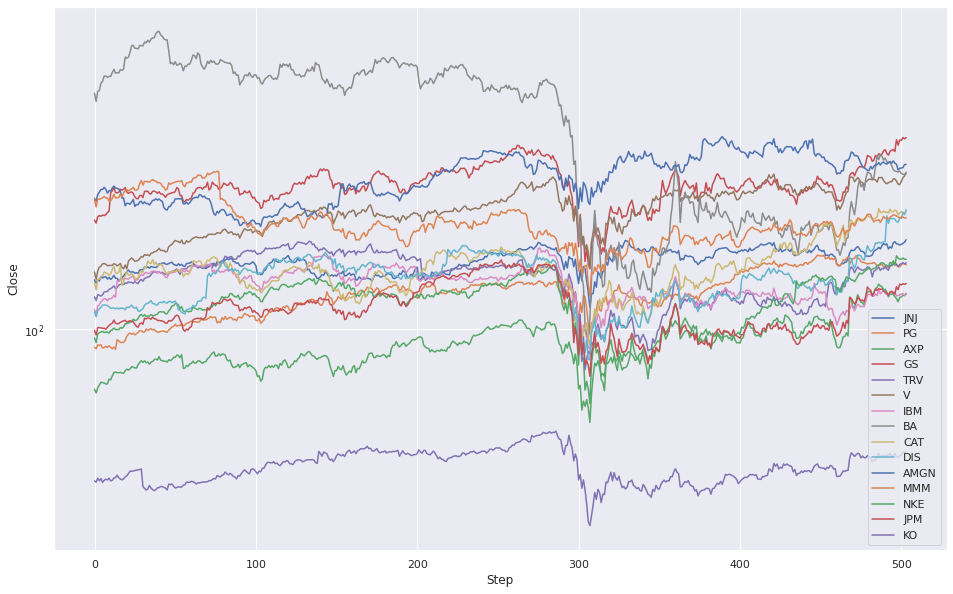

In [ ]:
plt.figure(figsize = (16,10))
for ticker, close in all_train_data_1.items():
    plt.plot(np.arange(len(close)), close, label=ticker) # 展示end-start

plt.legend()
plt.xlabel("Step")
plt.ylabel("Close")
plt.yscale("log")
plt.savefig('1_factor_show_log_price.png')
plt.show()

### epochs=1000

#### Training

In [ ]:
window_size = 256 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_1_factor_1000_epochs = Agent(state_size = window_size, 
                                window_size = window_size,
                                trend_data = all_train_data_1, 
                                skip = skip, 
                                batch_size = batch_size,
                                drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                                GD_learning_rate = 1e-5,
                                gamma = 0.95,
                                epsilon = 0.5,
                                epsilon_min = 0.01,
                                epsilon_decay = 0.9997,
                                no_of_factors = 1)

agent_1_factor_1000_epochs.train(iterations = 1000, checkpoint = 1, initial_money = None)

ticker: MRK, epoch: 1, total rewards: 19.19, return: 13.3020%, cost: 0.20, total money: 163.44,initial money: 144.26, epsion: 0.46
ticker: DIS, epoch: 2, total rewards: 13.18, return: 6.0475%, cost: 0.43, total money: 231.12,initial money: 217.94, epsion: 0.43
ticker: HON, epoch: 3, total rewards: 14.85, return: 5.6323%, cost: 0.50, total money: 278.51,initial money: 263.66, epsion: 0.40
ticker: CRM, epoch: 4, total rewards: 39.97, return: 14.7437%, cost: 0.74, total money: 311.07,initial money: 271.10, epsion: 0.37
ticker: AMGN, epoch: 5, total rewards: -13.91, return: -3.6243%, cost: 0.91, total money: 369.89,initial money: 383.80, epsion: 0.34
ticker: HD, epoch: 6, total rewards: 35.74, return: 10.3648%, cost: 0.90, total money: 380.56,initial money: 344.82, epsion: 0.32
ticker: KO, epoch: 7, total rewards: 2.63, return: 2.8020%, cost: 0.80, total money: 96.49,initial money: 93.86, epsion: 0.30
ticker: WMT, epoch: 8, total rewards: 10.31, return: 5.5228%, cost: 0.55, total money: 19

#### One prediction

In [ ]:
print_final_return(all_test_data_1, agent=agent_1_factor_1000_epochs, print_outcome=True, print_final_total_money=False)

Ticker INTC: total gains 33.7200, total investment 35.81%
Ticker TRV: total gains -41.6800, total investment -17.76%
Ticker AXP: total gains 8.9000, total investment 4.65%
Ticker CAT: total gains 30.3101, total investment 11.99%
Ticker JPM: total gains -35.0601, total investment -17.65%
Ticker CVX: total gains -15.8400, total investment -7.16%
Ticker V: total gains -8.3900, total investment -3.16%
Ticker MSFT: total gains 64.8101, total investment 32.05%
Ticker MMM: total gains -26.9600, total investment -7.06%
Ticker CSCO: total gains 17.3000, total investment 20.14%


5.186158402480941

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_1_factor_1000_iteration = []
for i in tqdm(range(100)):
    return_list_1_factor_1000_iteration.append(print_final_return(all_test_data_1, 
                                          agent=agent_1_factor_1000_epochs, 
                                          print_outcome=False, 
                                          print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_1_factor_1000_iteration)/len(return_list_1_factor_1000_iteration))
print('Standard Deviation is: ', round(np.std(return_list_1_factor_1000_iteration), 2))

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


100 times average return is:  6.8965749613207485
Standard Deviation is:  5.14


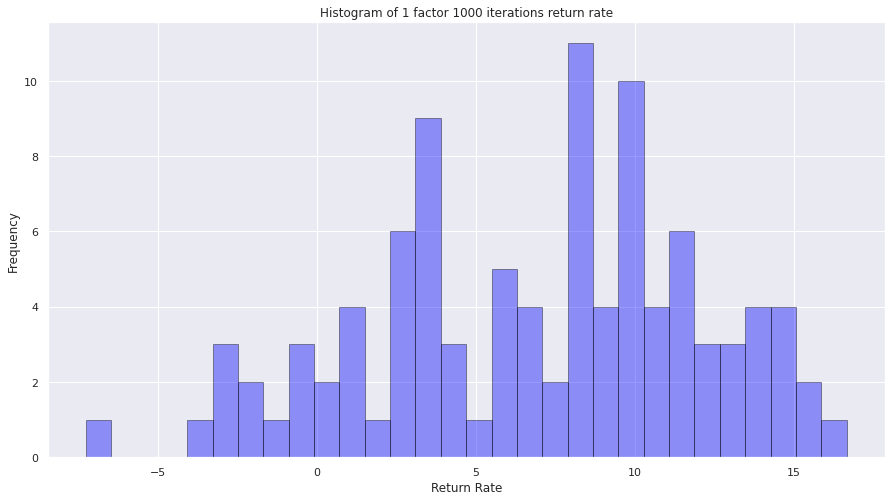

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.distplot(return_list_1_factor_1000_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 1 factor 1000 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('1_factor_1000_iteration_return_rate_histogram.png')

### epochs=500

#### Training

In [ ]:
window_size = 256 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_1_factor_500_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_1, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.5,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 1)

agent_1_factor_500_epochs.train(iterations = 500, checkpoint = 1, initial_money = None)

ticker: MRK, epoch: 1, total rewards: 14.31, return: 9.9219%, cost: 0.27, total money: 158.57,initial money: 144.26, epsion: 0.46
ticker: DIS, epoch: 2, total rewards: 12.74, return: 5.8456%, cost: 0.70, total money: 230.68,initial money: 217.94, epsion: 0.43
ticker: HON, epoch: 3, total rewards: 15.08, return: 5.7195%, cost: 0.83, total money: 278.74,initial money: 263.66, epsion: 0.40
ticker: CRM, epoch: 4, total rewards: 39.87, return: 14.7068%, cost: 1.10, total money: 310.97,initial money: 271.10, epsion: 0.37
ticker: AMGN, epoch: 5, total rewards: -11.32, return: -2.9495%, cost: 1.25, total money: 372.48,initial money: 383.80, epsion: 0.34
ticker: HD, epoch: 6, total rewards: 19.36, return: 5.6145%, cost: 1.20, total money: 364.18,initial money: 344.82, epsion: 0.32
ticker: KO, epoch: 7, total rewards: 8.80, return: 9.3757%, cost: 0.96, total money: 102.66,initial money: 93.86, epsion: 0.30
ticker: WMT, epoch: 8, total rewards: 2.81, return: 1.5053%, cost: 0.60, total money: 189.

#### One prediction

In [ ]:
print_final_return(all_test_data_1, agent=agent_1_factor_500_epochs, print_outcome=True, print_final_total_money=False)

Ticker INTC: total gains 16.2900, total investment 17.30%
Ticker TRV: total gains 11.4500, total investment 4.88%
Ticker AXP: total gains 45.0101, total investment 23.52%
Ticker CAT: total gains 86.3500, total investment 34.16%
Ticker JPM: total gains 8.9900, total investment 4.53%
Ticker CVX: total gains -61.4301, total investment -27.75%
Ticker V: total gains 64.4299, total investment 24.24%
Ticker MSFT: total gains 87.9200, total investment 43.47%
Ticker MMM: total gains -9.0599, total investment -2.37%
Ticker CSCO: total gains 2.0300, total investment 2.36%


12.433992177280167

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_1_factor_500_iteration = []
for i in tqdm(range(100)):
    return_list_1_factor_500_iteration.append(print_final_return(all_test_data_1, 
                                          agent=agent_1_factor_500_epochs, 
                                          print_outcome=False, 
                                          print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_1_factor_500_iteration)/len(return_list_1_factor_500_iteration))
print('Standard Deviation is: ', round(np.std(return_list_1_factor_500_iteration), 2))

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


100 times average return is:  7.424919795065031
Standard Deviation is:  4.59


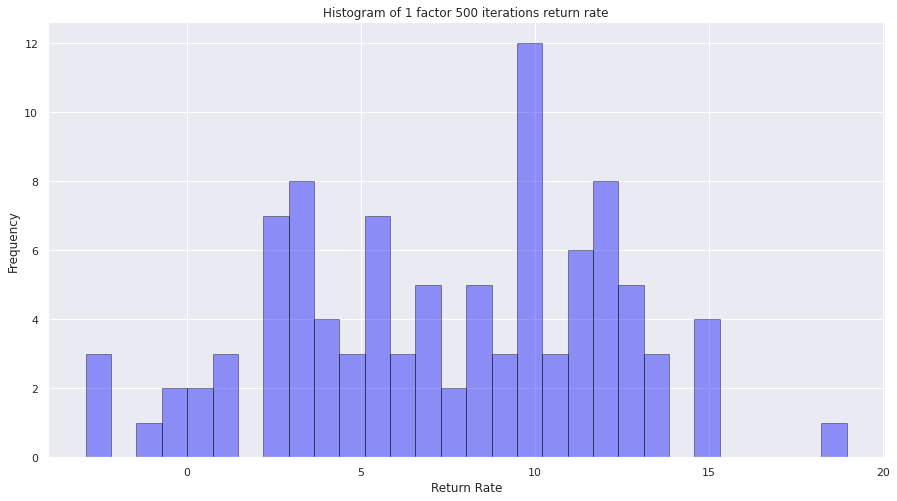

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.distplot(return_list_1_factor_500_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 1 factor 500 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('1_factor_500_iteration_return_rate_histogram.png')

### epochs=250

In [ ]:
window_size = 256 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_1_factor_250_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_1, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.5,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 1)

agent_1_factor_250_epochs.train(iterations = 250, checkpoint = 1, initial_money = None)

ticker: JNJ, epoch: 1, total rewards: 21.36, return: 8.3601%, cost: 0.32, total money: 276.86,initial money: 255.50, epsion: 0.46
ticker: PG, epoch: 2, total rewards: 6.42, return: 3.5166%, cost: 0.28, total money: 188.98,initial money: 182.56, epsion: 0.43
ticker: AXP, epoch: 3, total rewards: 18.24, return: 9.5318%, cost: 0.29, total money: 209.60,initial money: 191.36, epsion: 0.40
ticker: GS, epoch: 4, total rewards: 58.09, return: 16.8837%, cost: 0.54, total money: 402.15,initial money: 344.06, epsion: 0.37
ticker: TRV, epoch: 5, total rewards: 21.15, return: 9.0099%, cost: 0.60, total money: 255.89,initial money: 234.74, epsion: 0.34
ticker: V, epoch: 6, total rewards: 36.32, return: 13.6624%, cost: 0.64, total money: 302.16,initial money: 265.84, epsion: 0.32
ticker: IBM, epoch: 7, total rewards: 11.91, return: 5.4075%, cost: 0.65, total money: 232.20,initial money: 220.29, epsion: 0.30
ticker: BA, epoch: 8, total rewards: 11.10, return: 1.7140%, cost: 1.80, total money: 658.72,

In [ ]:
_, states_buy, states_sell, total_gains, invest = print_final_return(all_test_data_1, 
                                                                     agent=agent_1_factor_250_epochs, 
                                                                     print_outcome=True, 
                                                                     print_final_total_money=True,
                                                                     for_visualizing_graph=True)

Ticker AAPL: total gains 12.3250, total investment 15.61%
Ticker MRK: total gains -13.5115, total investment -9.37%
Ticker MSFT: total gains 65.6301, total investment 32.45%
Ticker WBA: total gains -35.0900, total investment -25.79%
Ticker WMT: total gains 9.4900, total investment 5.08%
Ticker HON: total gains 22.8999, total investment 8.69%
Ticker MCD: total gains 28.0900, total investment 7.98%
Ticker UNH: total gains -91.7099, total investment -18.83%
Ticker INTC: total gains 3.6200, total investment 3.84%
Ticker CSCO: total gains 14.2799, total investment 16.62%
Finally, with a principle of 100.00, we earned 3.63


#### Visualize agent's buying and selling points

Visualize CSCO agent buying and selling points

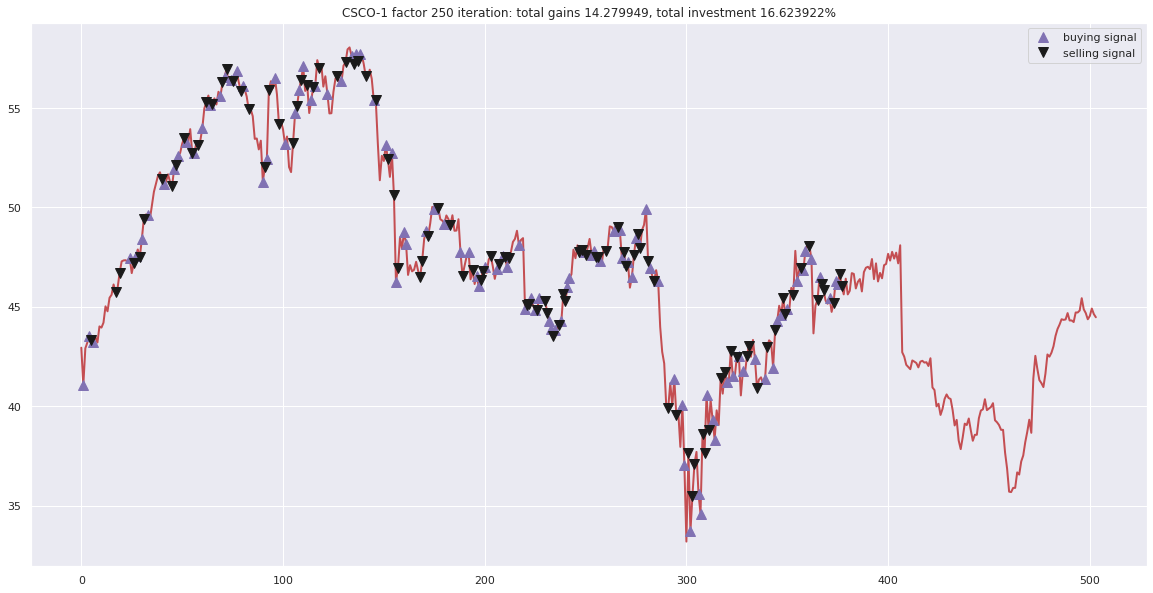

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(all_test_data_1['CSCO'], color='r', lw=2.)
plt.plot(all_test_data_1['CSCO'], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(all_test_data_1['CSCO'], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('CSCO-1 factor 250 iteration: total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_1_factor_250_iteration = []
for i in tqdm(range(100)):
    return_list_1_factor_250_iteration.append(print_final_return(all_test_data_1, 
                                          agent=agent_1_factor_250_epochs, 
                                          print_outcome=False, 
                                          print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_1_factor_250_iteration)/len(return_list_1_factor_250_iteration))
print('Standard Deviation is: ', round(np.std(return_list_1_factor_250_iteration), 2))

100%|██████████| 100/100 [00:46<00:00,  2.16it/s]


100 times average return is:  10.515976076764163
Standard Deviation is:  4.6


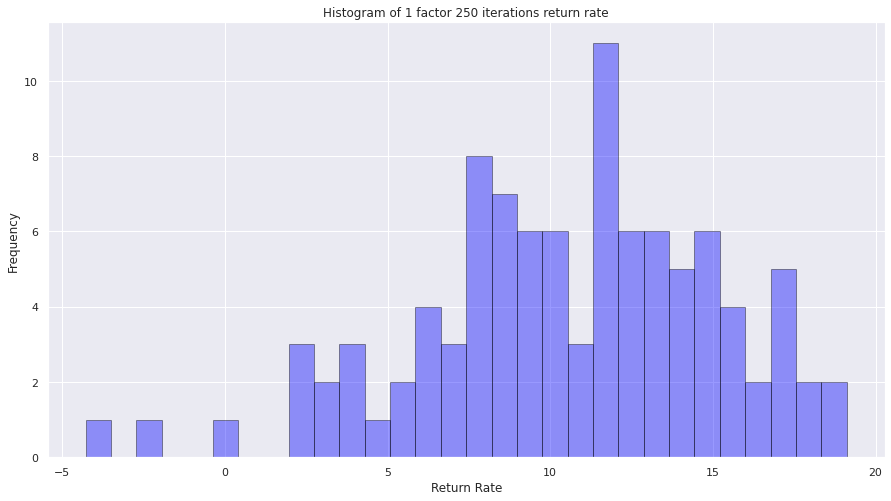

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.distplot(return_list_1_factor_250_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 1 factor 250 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('1_factor_250_iteration_return_rate_histogram.png')

### epochs=50

#### Training

In [ ]:
window_size = 256 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_1_factor_50_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_1, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.5,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 1)

agent_1_factor_50_epochs.train(iterations = 50, checkpoint = 1, initial_money = None)

ticker: MRK, epoch: 1, total rewards: 15.92, return: 11.0332%, cost: 0.27, total money: 160.17,initial money: 144.26, epsion: 0.46
ticker: DIS, epoch: 2, total rewards: 21.86, return: 10.0303%, cost: 0.52, total money: 239.80,initial money: 217.94, epsion: 0.43
ticker: HON, epoch: 3, total rewards: 22.86, return: 8.6702%, cost: 0.58, total money: 286.52,initial money: 263.66, epsion: 0.40
ticker: CRM, epoch: 4, total rewards: 24.71, return: 9.1148%, cost: 0.77, total money: 295.81,initial money: 271.10, epsion: 0.37
ticker: AMGN, epoch: 5, total rewards: -4.94, return: -1.2871%, cost: 0.95, total money: 378.86,initial money: 383.80, epsion: 0.34
ticker: HD, epoch: 6, total rewards: 18.24, return: 5.2897%, cost: 0.95, total money: 363.06,initial money: 344.82, epsion: 0.32
ticker: KO, epoch: 7, total rewards: 5.44, return: 5.7959%, cost: 0.82, total money: 99.30,initial money: 93.86, epsion: 0.30
ticker: WMT, epoch: 8, total rewards: 12.91, return: 6.9156%, cost: 0.56, total money: 199.

#### One prediction

In [ ]:
print_final_return(all_test_data_1, agent=agent_1_factor_50_epochs, print_outcome=True, print_final_total_money=False)

Ticker INTC: total gains 62.4300, total investment 66.30%
Ticker TRV: total gains 34.6900, total investment 14.78%
Ticker AXP: total gains 15.7299, total investment 8.22%
Ticker CAT: total gains 15.5100, total investment 6.14%
Ticker JPM: total gains -7.5500, total investment -3.80%
Ticker CVX: total gains 66.7100, total investment 30.13%
Ticker V: total gains 41.5899, total investment 15.64%
Ticker MSFT: total gains 46.3099, total investment 22.90%
Ticker MMM: total gains -47.2600, total investment -12.37%
Ticker CSCO: total gains 2.9300, total investment 3.41%


15.134807235219743

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_1_factor_50_iteration = []
for i in tqdm(range(100)):
    return_list_1_factor_50_iteration.append(print_final_return(all_test_data_1, 
                                          agent=agent_1_factor_50_epochs, 
                                          print_outcome=False, 
                                          print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_1_factor_50_iteration)/len(return_list_1_factor_50_iteration))
print('Standard Deviation is: ', round(np.std(return_list_1_factor_50_iteration), 2))

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


100 times average return is:  5.892336109285443
Standard Deviation is:  4.51


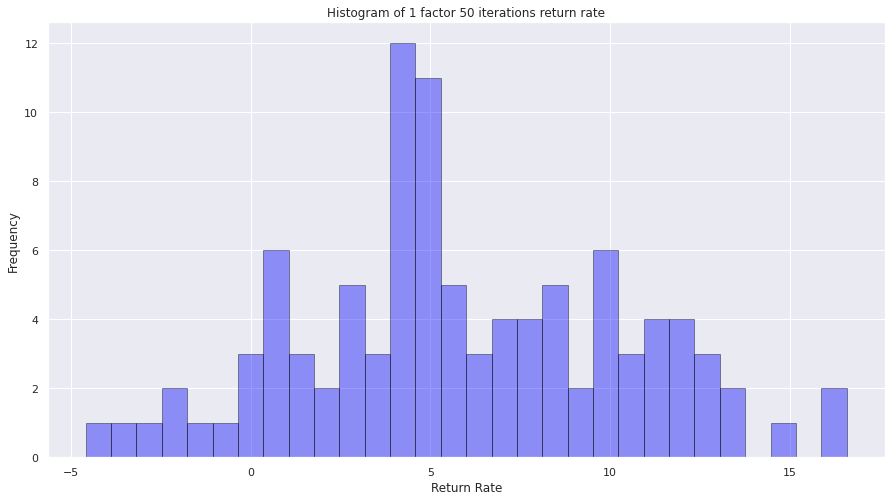

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.distplot(return_list_1_factor_50_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 1 factor 50 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('1_factor_50_iteration_return_rate_histogram.png')

## Train with 3 factors

### Loading Data

In [ ]:
train_start_date, train_end_date = "2020-01-01", "2020-12-31"
test_start_date, test_end_date = "2021-01-01", "2021-12-31"
all_train_data_3, all_test_data_3 = building_data(tickers, 
                                              train_start_date=train_start_date, 
                                              train_end_date=train_end_date, 
                                              test_start_date=test_start_date, 
                                              test_end_date=test_end_date,
                                              factors_1=False,
                                              factors_3=True,
                                              factors_6=False, 
                                              flatten=True,
                                              train_size=15,
                                              test_size=10)

Building training data...
preparing data for BA...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
BA
preparing data for UNH...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
UNH
preparing data for MCD...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
MCD
preparing data for CVX...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CVX
preparing data for AXP...
[*

### epochs=20

#### Training

In [ ]:
window_size = 64 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_3_factor = Agent(state_size = window_size, 
              window_size = window_size,
              trend_data = all_train_data_3, 
              skip = skip, 
              batch_size = batch_size,
              drop_out_rate = [0.2, 0.3, 0.4, 0.4, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
              GD_learning_rate = 1e-5,
              gamma = 0.95,
              epsilon = 0.5,
              epsilon_min = 0.01,
              epsilon_decay = 0.9997,
              no_of_factors = 3)

agent_3_factor.train(iterations = 20, checkpoint = 1, initial_money = None)

ticker: BA, epoch: 1, total rewards: -129.93, return: -19.4903%, cost: 5.85, total money: 536.71,initial money: 666.64, epsion: 0.46
ticker: UNH, epoch: 2, total rewards: 137.70, return: 23.5385%, cost: 4.53, total money: 722.70,initial money: 585.00, epsion: 0.43
ticker: MCD, epoch: 3, total rewards: 37.02, return: 9.2186%, cost: 3.32, total money: 438.60,initial money: 401.58, epsion: 0.40
ticker: CVX, epoch: 4, total rewards: -1.10, return: -0.4529%, cost: 2.03, total money: 241.76,initial money: 242.86, epsion: 0.37
ticker: AXP, epoch: 5, total rewards: -36.13, return: -14.3544%, cost: 1.26, total money: 215.57,initial money: 251.70, epsion: 0.34
ticker: AMGN, epoch: 6, total rewards: 22.50, return: 4.6855%, cost: 0.78, total money: 502.70,initial money: 480.20, epsion: 0.32
ticker: NKE, epoch: 7, total rewards: 38.47, return: 18.8209%, cost: 0.63, total money: 242.87,initial money: 204.40, epsion: 0.30
ticker: WMT, epoch: 8, total rewards: 12.18, return: 5.1202%, cost: 0.57, total

#### One prediction

In [ ]:
_, states_buy, states_sell, total_gains, invest = print_final_return(all_test_data_3, 
                                                                     agent=agent_3_factor, 
                                                                     print_outcome=True, 
                                                                     print_final_total_money=True, 
                                                                     for_visualizing_graph=True)

Ticker INTC: total gains -18.8100, total investment -15.46%
Ticker CSCO: total gains 11.4300, total investment 11.80%
Ticker DIS: total gains 39.9801, total investment 13.49%
Ticker AAPL: total gains 26.4125, total investment 17.59%
Ticker KO: total gains 2.1000, total investment 1.91%
Ticker V: total gains -7.4600, total investment -1.95%
Ticker MMM: total gains -14.7400, total investment -4.09%
Ticker IBM: total gains -36.9599, total investment -14.27%
Ticker TRV: total gains 21.8500, total investment 7.94%
Ticker CAT: total gains 87.0400, total investment 28.91%
Finally, with a principle of 100.00, we earned 4.59


#### Visualize agent's buying and selling points

Visualize CAT Agent buying and selling points

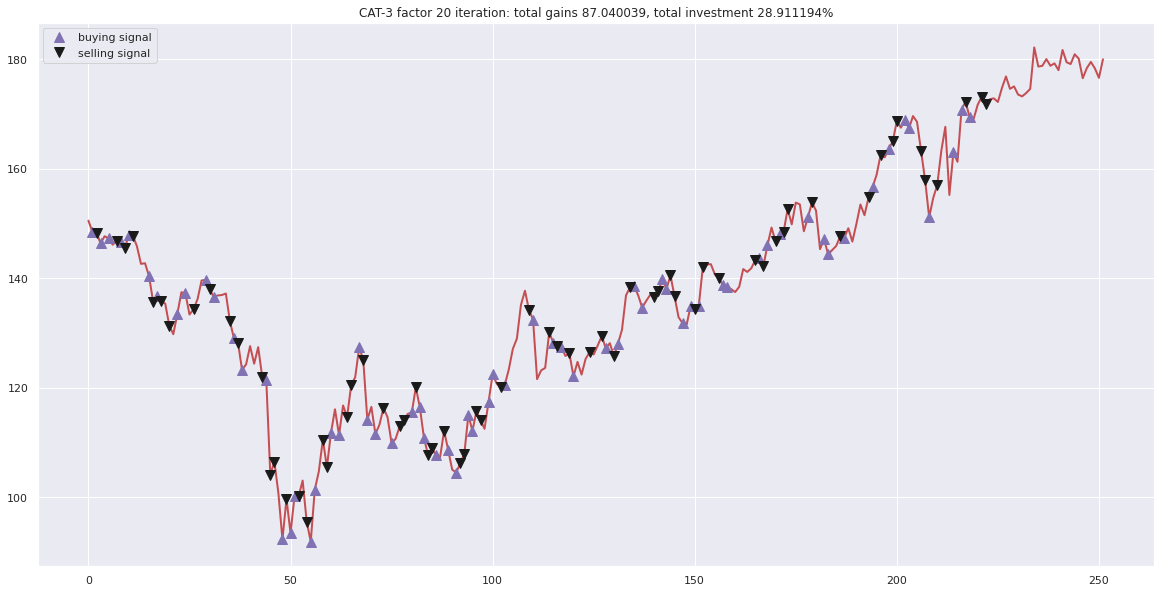

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(all_test_data_3['CAT'][:252], color='r', lw=2.)
plt.plot(all_test_data_3['CAT'][:252], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(all_test_data_3['CAT'][:252], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('CAT-3 factor 20 iteration: total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_3_factor_20_iteration = []
for i in tqdm(range(100)):
    return_list_3_factor_20_iteration.append(print_final_return(all_test_data_3, 
                                          agent=agent_3_factor, 
                                          print_outcome=False, 
                                          print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_3_factor_20_iteration)/len(return_list_3_factor_20_iteration))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_20_iteration), 2))

100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


100 times average return is:  1.3024147217894317
Standard Deviation is:  3.86


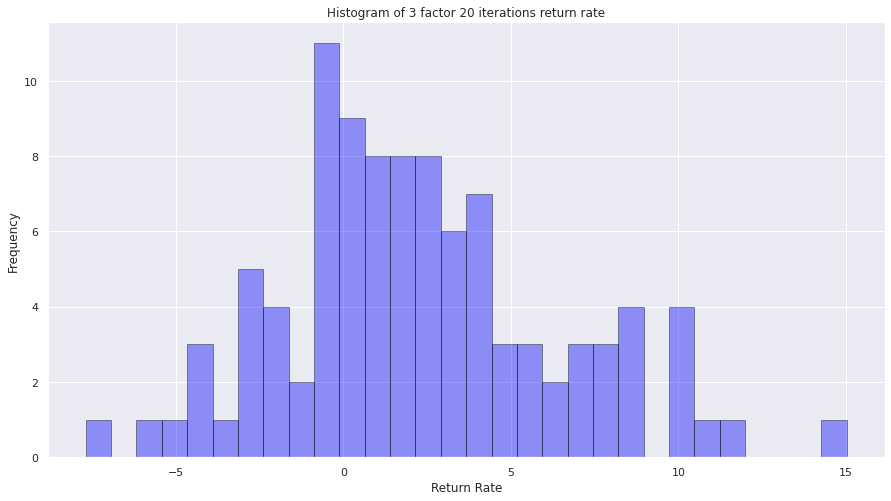

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.distplot(return_list_3_factor_20_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 20 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_20_iteration_return_rate_histogram.png')

### epochs=50

#### Training

In [ ]:
window_size = 64 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_3_factor_50_epoch = Agent(state_size = window_size, 
                    window_size = window_size,
                    trend_data = all_train_data_3, 
                    skip = skip, 
                    batch_size = batch_size,
                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                    GD_learning_rate = 1e-5,
                    gamma = 0.95,
                    epsilon = 0.5,
                    epsilon_min = 0.01,
                    epsilon_decay = 0.9997,
                    no_of_factors = 3)

agent_3_factor_50_epoch.train(iterations = 50, checkpoint = 1, initial_money = None)

ticker: JPM, epoch: 1, total rewards: -50.93, return: -18.0488%, cost: 2.22, total money: 231.25,initial money: 282.18, epsion: 0.46
ticker: NKE, epoch: 2, total rewards: 11.79, return: 5.7681%, cost: 1.49, total money: 216.19,initial money: 204.40, epsion: 0.43
ticker: V, epoch: 3, total rewards: 27.14, return: 7.1002%, cost: 2.07, total money: 409.38,initial money: 382.24, epsion: 0.40
ticker: AXP, epoch: 4, total rewards: 25.51, return: 10.1351%, cost: 1.78, total money: 277.21,initial money: 251.70, epsion: 0.37
ticker: CSCO, epoch: 5, total rewards: -2.41, return: -2.4886%, cost: 1.39, total money: 94.43,initial money: 96.84, epsion: 0.34
ticker: DIS, epoch: 6, total rewards: -32.70, return: -11.0324%, cost: 1.30, total money: 263.70,initial money: 296.40, epsion: 0.32
ticker: MCD, epoch: 7, total rewards: 80.55, return: 20.0583%, cost: 1.09, total money: 482.13,initial money: 401.58, epsion: 0.30
ticker: MMM, epoch: 8, total rewards: -24.50, return: -6.8055%, cost: 0.98, total mo

#### One prediction

In [ ]:
print_final_return(all_test_data_3, agent=agent_3_factor_50_epoch, print_outcome=True, print_final_total_money=False)

Ticker AAPL: total gains 8.3175, total investment 5.54%
Ticker BA: total gains 30.7100, total investment 4.61%
Ticker PG: total gains 49.4399, total investment 20.03%
Ticker MSFT: total gains 69.7201, total investment 21.70%
Ticker HON: total gains 56.4300, total investment 15.61%
Ticker WBA: total gains -16.1200, total investment -13.64%
Ticker GS: total gains -115.7300, total investment -24.69%
Ticker UNH: total gains 42.6400, total investment 7.29%
Ticker VZ: total gains 0.2500, total investment 0.20%
Ticker IBM: total gains -31.1568, total investment -12.03%


2.460923030391785

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_3_factor_50_iteration = []
for i in tqdm(range(100)):
    return_list_3_factor_50_iteration.append(print_final_return(all_test_data_3, 
                                                agent=agent_3_factor_50_epoch, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_3_factor_50_iteration)/len(return_list_3_factor_50_iteration))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_50_iteration), 2))

100%|██████████| 100/100 [00:11<00:00,  8.81it/s]


100 times average return is:  2.515917922082723


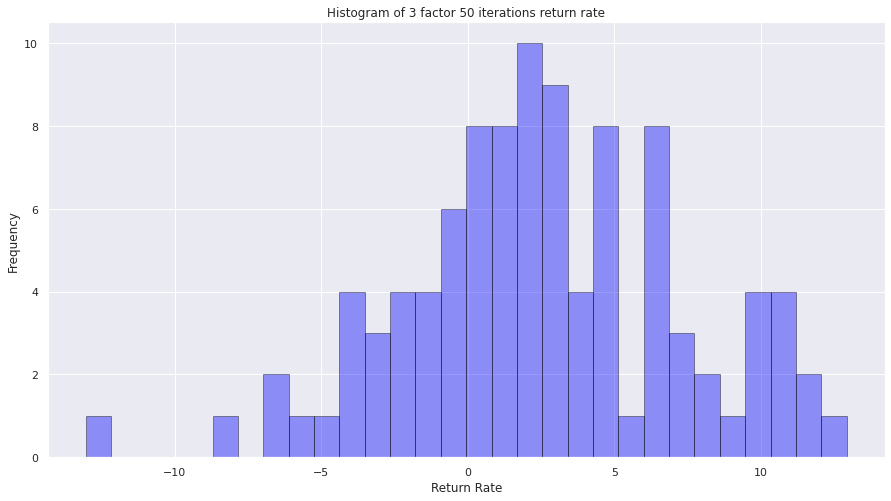

In [ ]:
sns.distplot(return_list_3_factor_50_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 50 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_50_iteration_return_rate_histogram.png')

### epochs=250

#### Training

In [ ]:
window_size = 64 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_3_factor_250_epoch = Agent(state_size = window_size, 
                    window_size = window_size,
                    trend_data = all_train_data_3, 
                    skip = skip, 
                    batch_size = batch_size,
                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                    GD_learning_rate = 1e-5,
                    gamma = 0.95,
                    epsilon = 0.5,
                    epsilon_min = 0.01,
                    epsilon_decay = 0.9997,
                    no_of_factors = 3)

agent_3_factor_250_epoch.train(iterations = 250, checkpoint = 1, initial_money = None)

ticker: JPM, epoch: 1, total rewards: -17.21, return: -6.0989%, cost: 2.31, total money: 264.97,initial money: 282.18, epsion: 0.46
ticker: NKE, epoch: 2, total rewards: 80.39, return: 39.3297%, cost: 1.45, total money: 284.79,initial money: 204.40, epsion: 0.43
ticker: V, epoch: 3, total rewards: 65.83, return: 17.2222%, cost: 2.30, total money: 448.07,initial money: 382.24, epsion: 0.40
ticker: AXP, epoch: 4, total rewards: -20.58, return: -8.1764%, cost: 2.08, total money: 231.12,initial money: 251.70, epsion: 0.37
ticker: CSCO, epoch: 5, total rewards: -0.25, return: -0.2581%, cost: 1.57, total money: 96.59,initial money: 96.84, epsion: 0.34
ticker: DIS, epoch: 6, total rewards: -32.69, return: -11.0290%, cost: 1.65, total money: 263.71,initial money: 296.40, epsion: 0.32
ticker: MCD, epoch: 7, total rewards: 10.78, return: 2.6844%, cost: 1.52, total money: 412.36,initial money: 401.58, epsion: 0.30
ticker: MMM, epoch: 8, total rewards: 57.01, return: 15.8361%, cost: 1.32, total mo

#### One prediction

In [ ]:
print_final_return(all_test_data_3, agent=agent_3_factor_250_epoch, print_outcome=True, print_final_total_money=False)

#### 100 predictions and visualization

In [ ]:
# see average performance
return_list_3_factor_250_iteration = []
for i in tqdm(range(100)):
    return_list_3_factor_250_iteration.append(print_final_return(all_test_data_3, 
                                                agent=agent_3_factor_250_epoch, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_3_factor_250_iteration)/len(return_list_3_factor_250_iteration))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_250_iteration), 2))

100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


100 times average return is:  3.6448755657471295


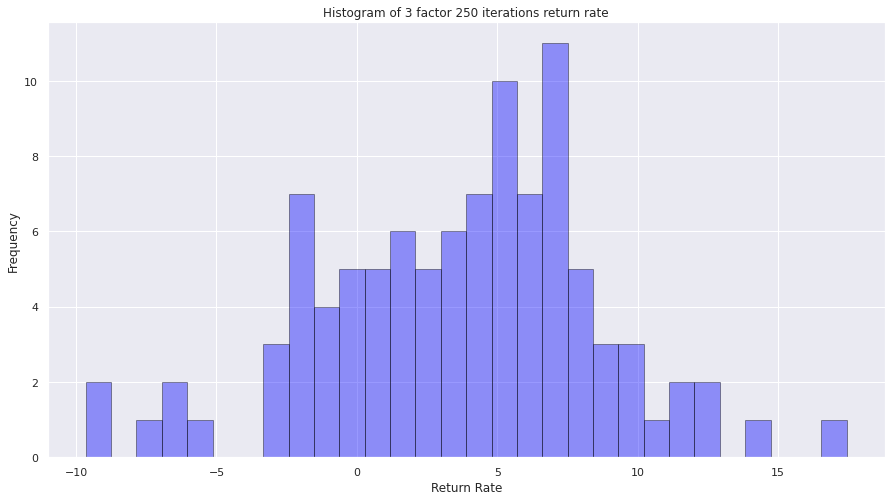

In [ ]:
sns.distplot(return_list_3_factor_250_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 250 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_250_iteration_return_rate_histogram.png')

### epochs=500

#### Training & 100 predictions and visualization

In [ ]:
window_size = 64 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_3_factor_500_epoch = Agent(state_size = window_size, 
                    window_size = window_size,
                    trend_data = all_train_data_3, 
                    skip = skip, 
                    batch_size = batch_size,
                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3],  # [0.2, 0.3, 0.4, 0.4, 0.3], 
                    GD_learning_rate = 1e-5,
                    gamma = 0.95,
                    epsilon = 0.5,
                    epsilon_min = 0.01,
                    epsilon_decay = 0.9997,
                    no_of_factors = 3)

agent_3_factor_500_epoch.train(iterations = 500, checkpoint = 1, initial_money = None)

print_final_return(all_test_data_3, agent=agent_3_factor_500_epoch, print_outcome=True, print_final_total_money=False)

# see average performance
return_list_3_factor_500_iteration = []
for i in tqdm(range(100)):
    return_list_3_factor_500_iteration.append(print_final_return(all_test_data_3, 
                                                agent=agent_3_factor_500_epoch, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print()
print('100 times average return is: ', sum(return_list_3_factor_500_iteration)/len(return_list_3_factor_500_iteration))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_500_iteration), 2))

ticker: JPM, epoch: 1, total rewards: -10.00, return: -3.5438%, cost: 2.60, total money: 272.18,initial money: 282.18, epsion: 0.46
ticker: NKE, epoch: 2, total rewards: 10.88, return: 5.3229%, cost: 1.48, total money: 215.28,initial money: 204.40, epsion: 0.43
ticker: V, epoch: 3, total rewards: 65.35, return: 17.0966%, cost: 2.31, total money: 447.59,initial money: 382.24, epsion: 0.40
ticker: AXP, epoch: 4, total rewards: -69.03, return: -27.4255%, cost: 1.78, total money: 182.67,initial money: 251.70, epsion: 0.37
ticker: CSCO, epoch: 5, total rewards: -17.63, return: -18.2053%, cost: 1.27, total money: 79.21,initial money: 96.84, epsion: 0.34
ticker: DIS, epoch: 6, total rewards: -32.72, return: -11.0391%, cost: 1.53, total money: 263.68,initial money: 296.40, epsion: 0.32
ticker: MCD, epoch: 7, total rewards: 111.89, return: 27.8624%, cost: 1.28, total money: 513.47,initial money: 401.58, epsion: 0.30
ticker: MMM, epoch: 8, total rewards: -11.18, return: -3.1056%, cost: 1.12, tot

100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


100 times average return is:  3.7746557984376694


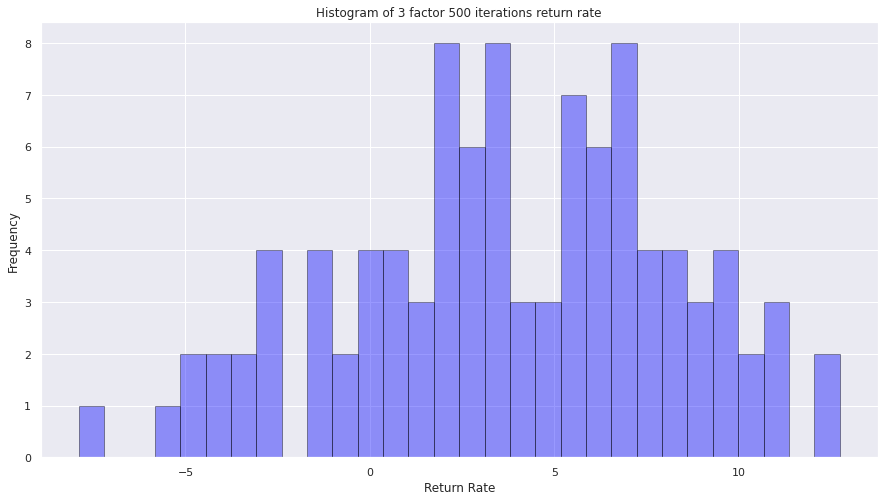

In [ ]:
sns.distplot(return_list_3_factor_500_iteration, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 500 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_500_iteration_return_rate_histogram.png')

## Train with 6 factors

### Loading Data

In [ ]:
train_start_date, train_end_date = "2019-01-01", "2020-12-31"
test_start_date, test_end_date = "2021-01-01", "2021-12-31"
all_train_data_6, all_test_data_6 = building_data(tickers, 
                                                train_start_date=train_start_date, 
                                                train_end_date=train_end_date, 
                                                test_start_date=test_start_date, 
                                                test_end_date=test_end_date,
                                                factors_1=False,
                                                factors_3=False,
                                                factors_6=True, 
                                                flatten=True)

Building training data...
preparing data for VZ...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
VZ
preparing data for AMGN...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AMGN
preparing data for WBA...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
WBA
preparing data for UNH...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
UNH
preparing data for NKE...


### epochs=20

#### Training

In [ ]:
window_size = 128 # 2 years
skip = 1
batch_size = 1024
agent_6_factor_20_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_6, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.7,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 6)

agent_6_factor_20_epochs.train(iterations = 20, checkpoint = 1, initial_money = None)

ticker: VZ, epoch: 1, total rewards: 5.97, return: 5.3285%, cost: 0.14, total money: 118.01,initial money: 112.04, epsion: 0.65
ticker: AMGN, epoch: 2, total rewards: 2.85, return: 0.7426%, cost: 0.75, total money: 386.65,initial money: 383.80, epsion: 0.60
ticker: WBA, epoch: 3, total rewards: -25.76, return: -18.9300%, cost: 0.58, total money: 110.32,initial money: 136.08, epsion: 0.56
ticker: UNH, epoch: 4, total rewards: 17.57, return: 3.6079%, cost: 1.03, total money: 504.55,initial money: 486.98, epsion: 0.52
ticker: NKE, epoch: 5, total rewards: 9.41, return: 6.3530%, cost: 1.03, total money: 157.53,initial money: 148.12, epsion: 0.48
ticker: PG, epoch: 6, total rewards: 3.76, return: 2.0596%, cost: 0.86, total money: 186.32,initial money: 182.56, epsion: 0.45
ticker: BA, epoch: 7, total rewards: 58.92, return: 9.0979%, cost: 2.60, total money: 706.54,initial money: 647.62, epsion: 0.41
ticker: MRK, epoch: 8, total rewards: 22.94, return: 15.9016%, cost: 1.71, total money: 167.1

#### One prediction

In [ ]:
_, states_buy, states_sell, total_gains, invest = print_final_return(all_test_data_6, 
                                                                     agent=agent_6_factor_20_epochs, 
                                                                     print_outcome=True, 
                                                                     print_final_total_money=True, 
                                                                     for_visualizing_graph=True)

Ticker MCD: total gains -12.4400, total investment -3.53%
Ticker TRV: total gains -33.2800, total investment -14.18%
Ticker AAPL: total gains 33.3000, total investment 42.17%
Ticker KO: total gains 20.5200, total investment 21.86%
Ticker CVX: total gains 27.9800, total investment 12.64%
Ticker V: total gains 10.2000, total investment 3.84%
Ticker CSCO: total gains 12.0800, total investment 14.06%
Ticker CAT: total gains -42.3100, total investment -16.74%
Ticker AXP: total gains 60.6800, total investment 31.71%
Ticker JPM: total gains -4.5200, total investment -2.28%
Finally, with a principle of 100.00, we earned 8.96


#### Visualize agent's buying and selling points

Visualizing JPM Agent buying and selling *points*

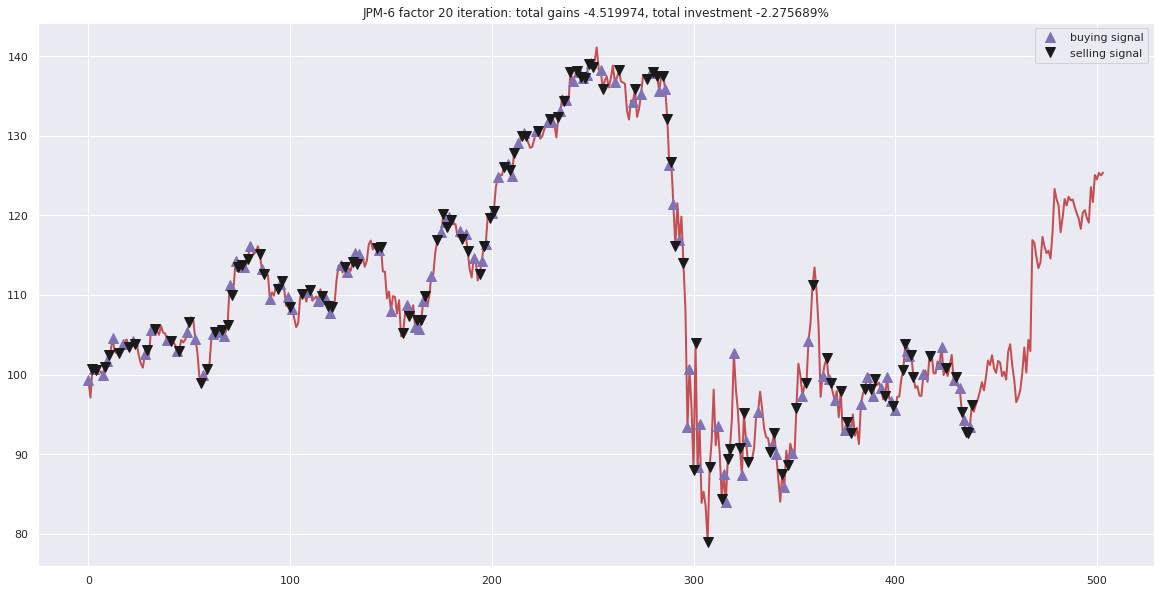

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(all_test_data_6['JPM'][:252*2], color='r', lw=2.)
plt.plot(all_test_data_6['JPM'][:252*2], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(all_test_data_6['JPM'][:252*2], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('JPM-6 factor 20 iteration: total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

#### Training & 100 predictions and visualization

In [ ]:
# see average performance
return_list_6_factor_20_iteration = []
for i in tqdm(range(100)):
    return_list_6_factor_20_iteration.append(print_final_return(all_test_data_6, 
                                                agent=agent_6_factor_20_epochs, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print('100 times average return is: ', sum(return_list_6_factor_20_iteration)/len(return_list_6_factor_20_iteration))
print('Standard Deviation is: ', round(np.std(return_list_6_factor_20_iteration), 2))

100%|██████████| 100/100 [00:30<00:00,  3.23it/s]

100 times average return is:  8.631387078069814
Standard Deviation is:  4.52


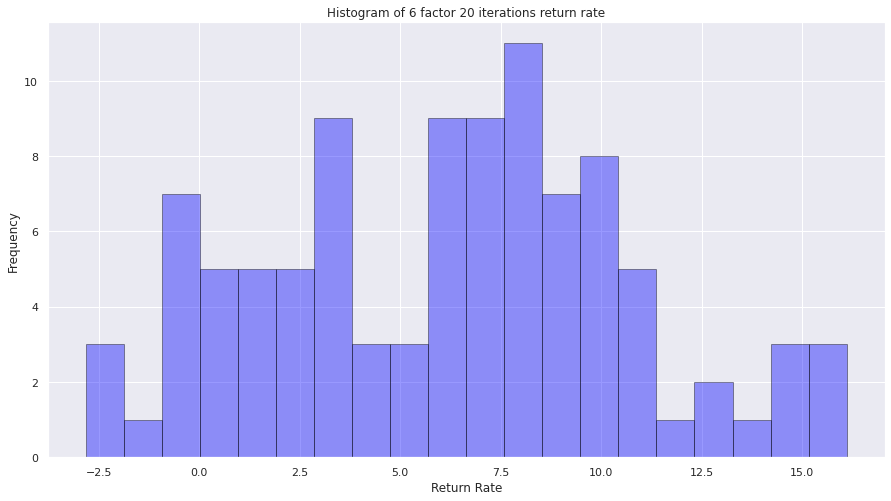

In [ ]:
sns.distplot(return_list_6_factor_20_iteration, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 6 factor 20 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('6_factor_20_iteration_return_rate_histogram.png')

### epochs=50

#### Training & 100 predictions and visualization

In [ ]:
window_size = 128 # 2 years
skip = 1
batch_size = 1024
agent_6_factor_50_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_6, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.7,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 6)

agent_6_factor_50_epochs.train(iterations = 50, checkpoint = 1, initial_money = None)

# see average performance
return_list_6_factor_50_iteration = []
for i in tqdm(range(100)):
    return_list_6_factor_50_iteration.append(print_final_return(all_test_data_6, 
                                                agent=agent_6_factor_50_epochs, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print('100 times average return is: ', sum(return_list_6_factor_50_iteration)/len(return_list_6_factor_50_iteration))
print('Standard Deviation is: ', round(np.std(return_list_6_factor_50_iteration), 2))

ticker: HON, epoch: 1, total rewards: 4.91, return: 1.8622%, cost: 0.95, total money: 268.57,initial money: 263.66, epsion: 0.65
ticker: INTC, epoch: 2, total rewards: 5.45, return: 5.7880%, cost: 0.66, total money: 99.61,initial money: 94.16, epsion: 0.60
ticker: MSFT, epoch: 3, total rewards: 33.25, return: 16.4408%, cost: 0.74, total money: 235.49,initial money: 202.24, epsion: 0.56
ticker: MCD, epoch: 4, total rewards: 34.20, return: 9.7126%, cost: 0.71, total money: 386.32,initial money: 352.12, epsion: 0.52
ticker: TRV, epoch: 5, total rewards: 8.61, return: 3.6679%, cost: 0.63, total money: 243.35,initial money: 234.74, epsion: 0.48
ticker: AMGN, epoch: 6, total rewards: -6.80, return: -1.7717%, cost: 0.88, total money: 377.00,initial money: 383.80, epsion: 0.45
ticker: CSCO, epoch: 7, total rewards: 11.99, return: 13.9581%, cost: 0.68, total money: 97.89,initial money: 85.90, epsion: 0.41
ticker: JPM, epoch: 8, total rewards: 10.10, return: 5.0851%, cost: 0.61, total money: 208

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]

100 times average return is:  5.571520910483545


#### Visualization of distribution

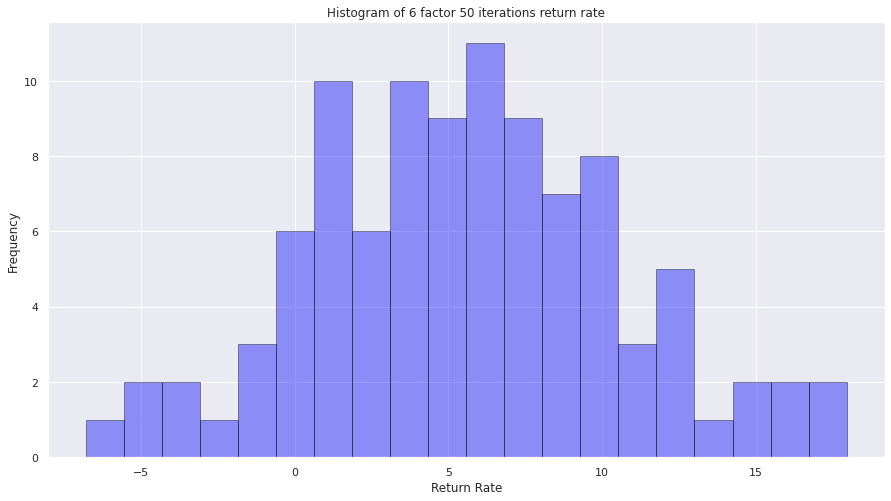

In [ ]:
sns.distplot(return_list_6_factor_50_iteration, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 6 factor 50 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('6_factor_50_iteration_return_rate_histogram.png')

### epochs=250

#### Training & 100 predictions and visualization

In [ ]:
window_size = 128 # 2 years
skip = 1
batch_size = 1024
agent_6_factor_250_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_6, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.7,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 6)

agent_6_factor_250_epochs.train(iterations = 250, checkpoint = 1, initial_money = None)

# see average performance
return_list_6_factor_250_iteration = []
for i in tqdm(range(100)):
    return_list_6_factor_250_iteration.append(print_final_return(all_test_data_6, 
                                                agent=agent_6_factor_250_epochs, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
print('100 times average return is: ', sum(return_list_6_factor_250_iteration)/len(return_list_6_factor_250_iteration))
print('Standard Deviation is: ', round(np.std(return_list_6_factor_250_iteration), 2))

ticker: HON, epoch: 1, total rewards: 18.38, return: 6.9711%, cost: 1.07, total money: 282.04,initial money: 263.66, epsion: 0.65
ticker: INTC, epoch: 2, total rewards: -1.27, return: -1.3488%, cost: 0.63, total money: 92.89,initial money: 94.16, epsion: 0.60
ticker: MSFT, epoch: 3, total rewards: 11.62, return: 5.7457%, cost: 0.67, total money: 213.86,initial money: 202.24, epsion: 0.56
ticker: MCD, epoch: 4, total rewards: 44.41, return: 12.6122%, cost: 0.68, total money: 396.53,initial money: 352.12, epsion: 0.52
ticker: TRV, epoch: 5, total rewards: 7.49, return: 3.1908%, cost: 0.61, total money: 242.23,initial money: 234.74, epsion: 0.48
ticker: AMGN, epoch: 6, total rewards: -27.38, return: -7.1339%, cost: 0.78, total money: 356.42,initial money: 383.80, epsion: 0.45
ticker: CSCO, epoch: 7, total rewards: 5.51, return: 6.4144%, cost: 0.66, total money: 91.41,initial money: 85.90, epsion: 0.41
ticker: JPM, epoch: 8, total rewards: 50.26, return: 25.3046%, cost: 0.55, total money: 

100%|██████████| 100/100 [00:28<00:00,  3.51it/s]

100 times average return is:  5.978486912188719


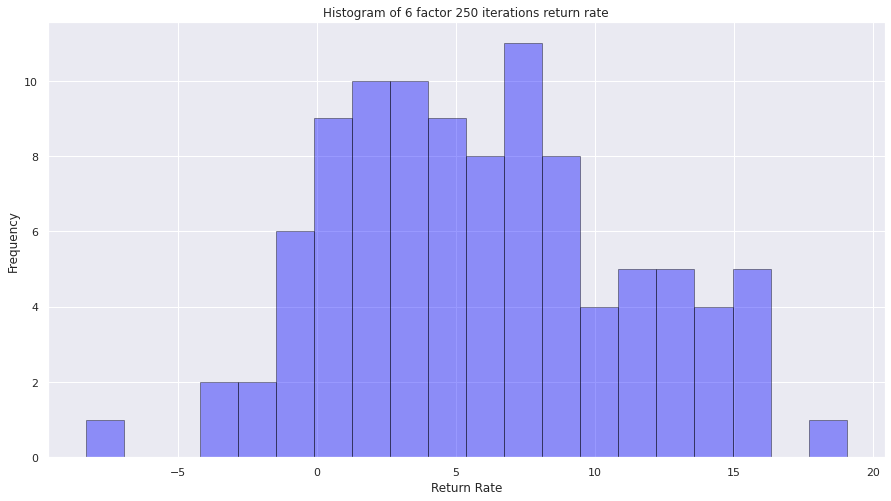

In [ ]:
sns.distplot(return_list_6_factor_250_iteration, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 6 factor 250 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('6_factor_250_iteration_return_rate_histogram.png')

### epochs=500

#### Training & 100 predictions and visualization

In [ ]:
window_size = 128 # 2 years
skip = 1
batch_size = 1024
agent_6_factor_500_epochs = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_6, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.7,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 6)

agent_6_factor_500_epochs.train(iterations = 500, checkpoint = 1, initial_money = None)

# see average performance
return_list_6_factor_500_iteration = []
for i in tqdm(range(100)):
    return_list_6_factor_500_iteration.append(print_final_return(all_test_data_6, 
                                                agent=agent_6_factor_500_epochs, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
    
print('100 times average return is: ', sum(return_list_6_factor_500_iteration)/len(return_list_6_factor_500_iteration))
print('Standard Deviation is: ', round(np.std(return_list_6_factor_500_iteration), 2))

ticker: HON, epoch: 1, total rewards: 36.49, return: 13.8398%, cost: 1.10, total money: 300.15,initial money: 263.66, epsion: 0.65
ticker: INTC, epoch: 2, total rewards: 7.00, return: 7.4341%, cost: 0.63, total money: 101.16,initial money: 94.16, epsion: 0.60
ticker: MSFT, epoch: 3, total rewards: 10.83, return: 5.3550%, cost: 0.75, total money: 213.07,initial money: 202.24, epsion: 0.56
ticker: MCD, epoch: 4, total rewards: 6.36, return: 1.8062%, cost: 0.78, total money: 358.48,initial money: 352.12, epsion: 0.52
ticker: TRV, epoch: 5, total rewards: 19.85, return: 8.4562%, cost: 0.57, total money: 254.59,initial money: 234.74, epsion: 0.48
ticker: AMGN, epoch: 6, total rewards: 20.66, return: 5.3830%, cost: 0.95, total money: 404.46,initial money: 383.80, epsion: 0.45
ticker: CSCO, epoch: 7, total rewards: -2.80, return: -3.2596%, cost: 0.70, total money: 83.10,initial money: 85.90, epsion: 0.41
ticker: JPM, epoch: 8, total rewards: 33.29, return: 16.7607%, cost: 0.55, total money: 2

100%|██████████| 100/100 [00:29<00:00,  3.45it/s]

100 times average return is:  6.07980817701359


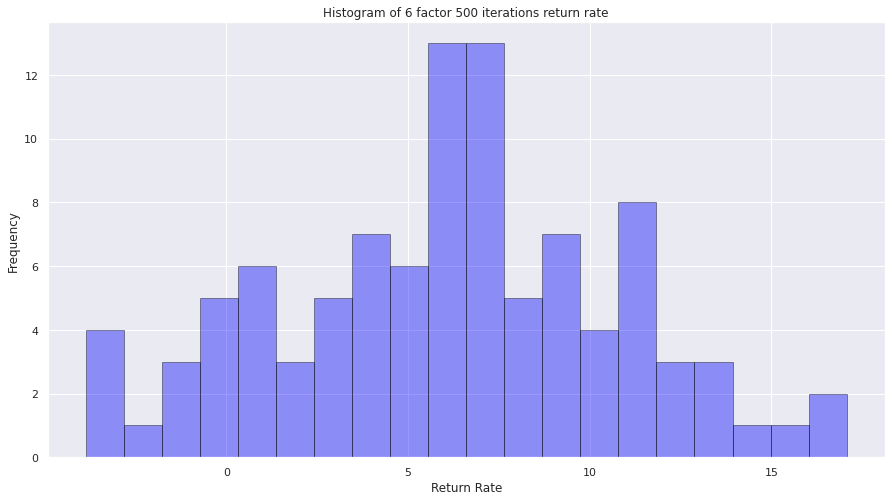

In [ ]:
sns.distplot(return_list_6_factor_500_iteration, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 6 factor 500 iterations return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('6_factor_500_iteration_return_rate_histogram.png')

# Clustering Stock Tickers

Use KMeans (with or without PCA) to cluster tickers, and select the top 2 cluster and seperately split them into training and testing dataset, and see how the model performs with 3 factors and 6 factors.

In [ ]:
def put_all_closes_together(all_train_data, no_of_factors, tickers_list, start_date=train_start_date, end_date=train_end_date):
    close_price = {}
    for ticker in tickers_list:
        close_price[ticker] = all_train_data[ticker][: len(all_train_data[ticker])/no_of_factors]
    return pd.DataFrame(close_price)

### Download Data

In [ ]:
# prepare the data
tickers_list = ticker_dow
movements = pd.DataFrame()
for ticker in tickers_list:
    stock_data = get_company_stock_data(ticker, 
                                        start_date=train_start_date, 
                                        end_date=train_end_date)

    # 添加difference
    stock_data = add_difference(stock_data)

    movements[ticker] = stock_data[['difference']]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [ ]:
movements.head(2)

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,1.155003,4.250000,2.500000,10.240021,4.879997,3.779999,0.990002,4.580002,1.409996,NaN,...,1.326340,2.809998,2.449997,1.459999,1.860001,4.880005,4.139999,0.880001,1.769997,2.010002
2019-01-03,0.930000,5.509995,1.949997,10.339996,5.059998,4.679993,1.450001,3.220001,2.709999,NaN,...,2.022896,2.990005,2.110001,2.120003,2.240005,7.349991,3.400002,0.930000,1.369995,2.010002


### Build KMeans Model

In [ ]:
# since DOW has NAN value, drop this column
movements = movements.drop(['DOW'], axis=1)

In [ ]:
# Define a normalizer
normalizer = Normalizer()

# Create Kmeans model
kmeans = KMeans(n_clusters = 3, max_iter = 5000) # DJI用2类吧，因为一共就30个票

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer, kmeans)

In [ ]:
# Fit pipeline to daily stock movements
movements_correct = movements.T
pipeline.fit(movements_correct)
labels = pipeline.predict(movements_correct)

In [ ]:
tickers_list.remove('DOW')

In [ ]:
df1 = pd.DataFrame({'labels':labels,
                    'companies':list(tickers_list)}).sort_values(by=['labels'], axis = 0)

We found there are 2 largest clusters, and we will train seperately on them (visualization of Clustering here)

In [ ]:
# Define a normalizer
normalizer = Normalizer()
# Reduce the data
reduced_data = PCA(n_components = 2)
# Create Kmeans model
kmeans = KMeans(n_clusters = 3, max_iter = 1000)
# Make a pipeline chaining normalizer, pca and kmeans
pipeline = make_pipeline(normalizer, reduced_data, kmeans)
# Fit pipeline to daily stock movements
pipeline.fit(movements_correct)
# Prediction
labels = pipeline.predict(movements_correct)
# Create dataframe to store companies and predicted labels
df2 = pd.DataFrame({'labels':labels,'companies':list(tickers_list)}).sort_values(by=['labels'],axis = 0)

### Visualize KMeans result

<Figure size 1152x720 with 0 Axes>

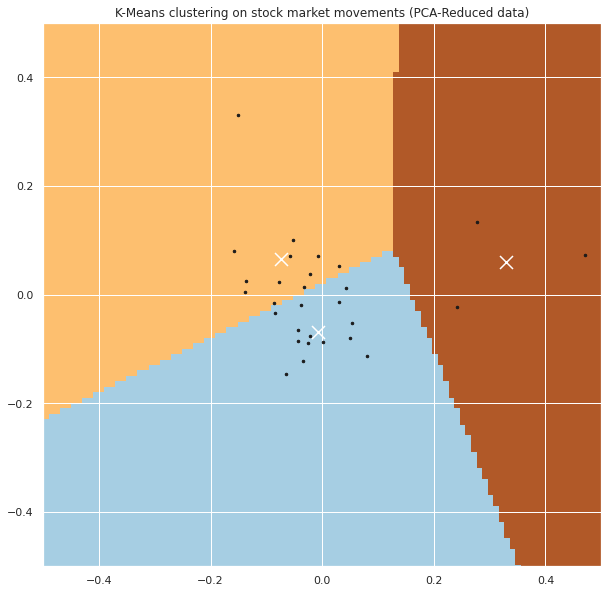

In [ ]:
normalizer = Normalizer() # Define a Normalizer
norm_movements = normalizer.fit_transform(movements_correct)

reduced_data = PCA(n_components = 2).fit_transform(norm_movements)

# Define step size of mesh
h = 0.01

# Plot the decision boundary
x_min,x_max = reduced_data[:,0].min()-1, reduced_data[:,0].max() + 1
y_min,y_max = reduced_data[:,1].min()-1, reduced_data[:,1].max() + 1
xx,yy = np.meshgrid(np.arange(x_min,x_max,h),np.arange(y_min,y_max,h))

# Obtain labels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# Define color plot
cmap = plt.cm.Paired

# Plotting figure
plt.figure(figsize=(16, 10))
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z,interpolation = 'nearest',
           extent=(xx.min(), 
                   xx.max(), 
                   yy.min(), 
                   yy.max()), 
           cmap = cmap,
           aspect = 'auto', 
           origin = 'lower')

plt.plot(reduced_data[:,0],
         reduced_data[:,1],
         'k.',
         markersize = 5)

# Plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_

plt.scatter(centroids[:,0],
            centroids[:,1],
            marker = 'x',
            s = 169,
            linewidths = 3,
            color = 'w',
            zorder = 10)
plt.title('K-Means clustering on stock market movements (PCA-Reduced data)')
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.show()

## Get names for cluster 1 and 2, and train & test size

In [ ]:
detail = Counter(df2.labels.to_list())
most_common_2 = [a for (a, b) in detail.most_common(2)]

cluster_1_ticker_names = df2[df2.labels == most_common_2[0]].companies.to_list()
cluster_2_ticker_names = df2[df2.labels == most_common_2[1]].companies.to_list()

# 自动决定train和test的大小，用70%的train，30%的test
test_no_1 = int(len(cluster_1_ticker_names) * 0.3)
train_no_1 = len(cluster_1_ticker_names) - test_no_1 # 更希望去train
test_no_2 = int(len(cluster_2_ticker_names) * 0.3)
train_no_2 = len(cluster_2_ticker_names) - test_no_2 # 更希望去train

In [ ]:
cluster_1_ticker_names

['JNJ',
 'V',
 'TRV',
 'PG',
 'NKE',
 'MCD',
 'KO',
 'JPM',
 'INTC',
 'HON',
 'WMT',
 'DIS',
 'AXP',
 'HD']

## Get stock data for cluster 1

In [ ]:
train_start_date, train_end_date = "2019-01-01", "2020-12-31"
test_start_date, test_end_date = "2021-01-01", "2021-12-31"

all_train_data_3_cluster_1, all_test_data_3_cluster_1 = building_data(tickers=cluster_1_ticker_names,
                                                                            train_start_date=train_start_date, 
                                                                            train_end_date=train_end_date, 
                                                                            test_start_date=test_start_date, 
                                                                            test_end_date=test_end_date,
                                                                            factors_1=False,
                                                                            factors_3=True,
                                                                            factors_6=False, 
                                                                            flatten=True,
                                                                            train_size=train_no_1, # 这里两个都要减一，不然容易出现'a' cannot be empty unless no samples are taken "
                                                                            test_size=test_no_1)

Building training data...
preparing data for TRV...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TRV
preparing data for WMT...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
WMT
preparing data for PG...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PG
preparing data for NKE...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
NKE
preparing data for AXP...
[*

### Train on cluster 1

In [ ]:
window_size = 128
skip = 1
batch_size = 1024
agent_3_factor_cluster_1 = Agent(state_size = window_size, 
                                    window_size = window_size,
                                    trend_data = all_train_data_3_cluster_1, 
                                    skip = skip, 
                                    batch_size = batch_size,
                                    drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                    GD_learning_rate = 1e-5,
                                    gamma = 0.95,
                                    epsilon = 0.5,
                                    epsilon_min = 0.01,
                                    epsilon_decay = 0.9997,
                                    no_of_factors = 3)

agent_3_factor_cluster_1.train(iterations = 100, checkpoint = 1, initial_money = None)

ticker: TRV, epoch: 1, total rewards: 23.46, return: 9.9940%, cost: 0.36, total money: 258.20,initial money: 234.74, epsion: 0.46
ticker: WMT, epoch: 2, total rewards: 13.41, return: 7.1834%, cost: 0.29, total money: 200.09,initial money: 186.68, epsion: 0.43
ticker: PG, epoch: 3, total rewards: 22.24, return: 12.1823%, cost: 0.27, total money: 204.80,initial money: 182.56, epsion: 0.40
ticker: NKE, epoch: 4, total rewards: 11.06, return: 7.4669%, cost: 0.23, total money: 159.18,initial money: 148.12, epsion: 0.37
ticker: AXP, epoch: 5, total rewards: 11.37, return: 5.9417%, cost: 0.23, total money: 202.73,initial money: 191.36, epsion: 0.34
ticker: DIS, epoch: 6, total rewards: 6.16, return: 2.8265%, cost: 0.31, total money: 224.10,initial money: 217.94, epsion: 0.32
ticker: HD, epoch: 7, total rewards: 35.13, return: 10.1879%, cost: 0.44, total money: 379.95,initial money: 344.82, epsion: 0.30
ticker: KO, epoch: 8, total rewards: 8.72, return: 9.2904%, cost: 0.37, total money: 102.58

### Test on cluster 1

In [ ]:
_, states_buy, states_sell, total_gains, invest = print_final_return(all_test_data_3_cluster_1, 
                                                                     agent=agent_3_factor_cluster_1, 
                                                                     print_outcome=True, 
                                                                     print_final_total_money=True, 
                                                                     for_visualizing_graph=True)
# print_final_return(all_test_data_3_cluster_1, agent=agent_3_factor_cluster_1, print_outcome=True, print_final_total_money=True)

Ticker V: total gains 150.4299, total investment 56.59%
Ticker JNJ: total gains -15.8800, total investment -6.22%
Ticker MCD: total gains 68.7700, total investment 19.53%
Ticker JPM: total gains 31.2101, total investment 15.71%
Finally, with a principle of 100.00, we earned 21.40


#### Visualize agent's buying and selling points

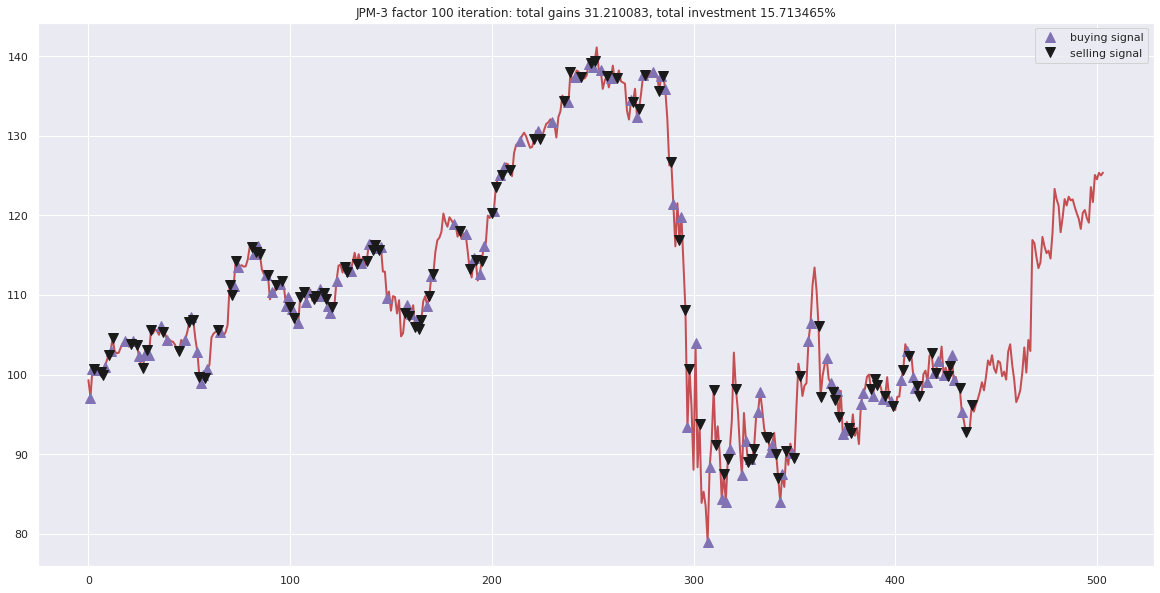

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(all_test_data_3_cluster_1['JPM'][:252*2], color='r', lw=2.)
plt.plot(all_test_data_3_cluster_1['JPM'][:252*2], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(all_test_data_3_cluster_1['JPM'][:252*2], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('JPM-3 factor 100 iteration: total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

### 100 predictions and visualization

In [ ]:
# see average performance
return_list_3_factor_100_iteration_cluster_1 = []
for i in tqdm(range(100)):
    return_list_3_factor_100_iteration_cluster_1.append(print_final_return(all_test_data_3_cluster_1, 
                                                agent=agent_3_factor_cluster_1, 
                                                print_outcome=False, 
                                                print_final_total_money=False))
    
print('100 times average return is: ', sum(return_list_3_factor_100_iteration_cluster_1)/len(return_list_3_factor_100_iteration_cluster_1))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_100_iteration_cluster_1), 2))

100%|██████████| 100/100 [00:12<00:00,  7.94it/s]

100 times average return is:  10.079158195308208
Standard Deviation is:  8.09


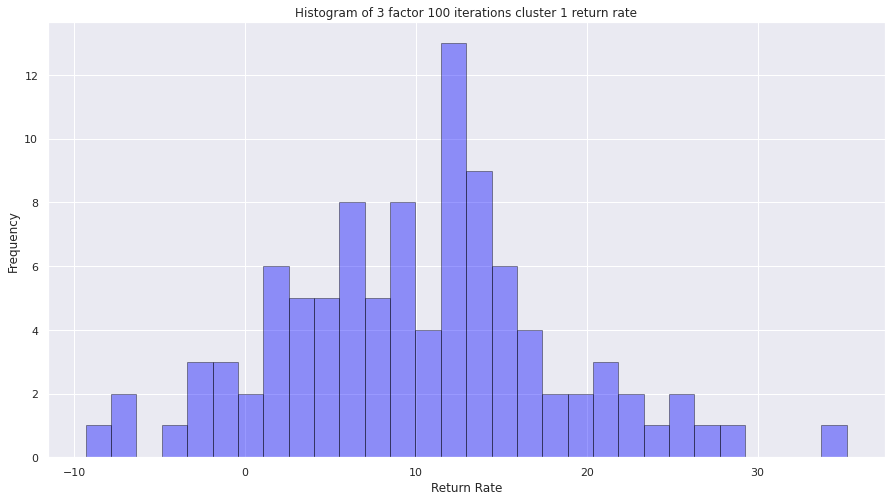

In [ ]:
sns.distplot(return_list_3_factor_100_iteration_cluster_1, hist=True, kde=False, 
             bins=30, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 100 iterations cluster 1 return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_100_iteration_cluster_1_return_rate_histogram.png')

## Get stock data for cluster 2

In [ ]:
train_start_date, train_end_date = "2019-01-01", "2020-12-31"
test_start_date, test_end_date = "2021-01-01", "2021-12-31"

all_train_data_3_cluster_2, all_test_data_3_cluster_2 = building_data(tickers=cluster_2_ticker_names,
                                                                    train_start_date=train_start_date, 
                                                                    train_end_date=train_end_date, 
                                                                    test_start_date=test_start_date, 
                                                                    test_end_date=test_end_date,
                                                                    factors_1=False,
                                                                    factors_3=True,
                                                                    factors_6=False, 
                                                                    flatten=True,
                                                                    train_size=train_no_2,
                                                                    test_size=test_no_2)

Building training data...
preparing data for CSCO...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CSCO
preparing data for GS...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GS
preparing data for WBA...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
WBA
preparing data for AMGN...
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
AMGN
preparing data for CVX..

### Train on cluster 2

In [ ]:
window_size = 64 # 理论来说，更大的window_size应该对应更长的training period，如果是1年的话，尽量用64，n年就用64*n
skip = 1
batch_size = 1024
agent_3_factor_cluster_2 = Agent(state_size = window_size, 
                                window_size = window_size,
                                trend_data = all_train_data_3_cluster_2, 
                                skip = skip, 
                                batch_size = batch_size,
                                drop_out_rate = [0.3, 0.3, 0.3, 0.3, 0.3], 
                                GD_learning_rate = 1e-5,
                                gamma = 0.95,
                                epsilon = 0.5,
                                epsilon_min = 0.01,
                                epsilon_decay = 0.9997,
                                no_of_factors = 3)

agent_3_factor_cluster_2.train(iterations = 100, checkpoint = 1, initial_money = None)

ticker: CSCO, epoch: 1, total rewards: 1.62, return: 1.8859%, cost: 0.14, total money: 87.52,initial money: 85.90, epsion: 0.46
ticker: GS, epoch: 2, total rewards: 21.85, return: 6.3506%, cost: 0.95, total money: 365.91,initial money: 344.06, epsion: 0.43
ticker: WBA, epoch: 3, total rewards: -6.05, return: -4.4459%, cost: 0.70, total money: 130.03,initial money: 136.08, epsion: 0.40
ticker: AMGN, epoch: 4, total rewards: 35.08, return: 9.1402%, cost: 0.82, total money: 418.88,initial money: 383.80, epsion: 0.37
ticker: CVX, epoch: 5, total rewards: 11.65, return: 5.2624%, cost: 0.83, total money: 233.03,initial money: 221.38, epsion: 0.34
ticker: VZ, epoch: 6, total rewards: 8.82, return: 7.8722%, cost: 0.45, total money: 120.86,initial money: 112.04, epsion: 0.32
ticker: MRK, epoch: 7, total rewards: 16.73, return: 11.5955%, cost: 0.44, total money: 160.98,initial money: 144.26, epsion: 0.30
ticker: CAT, epoch: 8, total rewards: -2.50, return: -0.9891%, cost: 0.42, total money: 250.

### Test on cluster 2

In [ ]:
_, states_buy, states_sell, total_gains, invest = print_final_return(all_test_data_3_cluster_2, 
                                                                     agent=agent_3_factor_cluster_2, 
                                                                     print_outcome=True, 
                                                                     print_final_total_money=True, 
                                                                     for_visualizing_graph=True)

Ticker MMM: total gains -26.3201, total investment -6.89%
Ticker IBM: total gains -2.3997, total investment -1.09%
Ticker BA: total gains 308.8102, total investment 47.68%
Finally, with a principle of 100.00, we earned 13.23


#### Visualize agent's buying and selling points

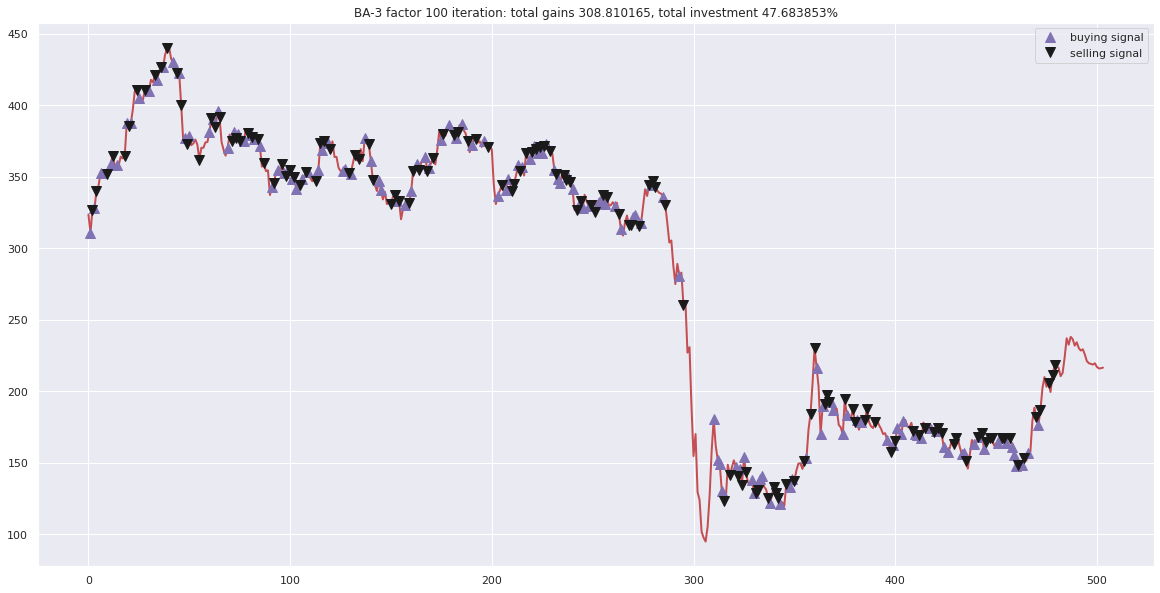

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(all_test_data_3_cluster_2['BA'][:252*2], color='r', lw=2.)
plt.plot(all_test_data_3_cluster_2['BA'][:252*2], '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(all_test_data_3_cluster_2['BA'][:252*2], 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('BA-3 factor 100 iteration: total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

### 100 predictions and visualization

In [ ]:
# see average performance
return_list_3_factor_100_iteration_cluster_2 = []
for i in tqdm(range(100)):
    return_list_3_factor_100_iteration_cluster_2.append(print_final_return(all_test_data_3_cluster_2, 
                                                                            agent=agent_3_factor_cluster_2, 
                                                                            print_outcome=False, 
                                                                            print_final_total_money=False))
    
print('100 times average return is: ', sum(return_list_3_factor_100_iteration_cluster_2)/len(return_list_3_factor_100_iteration_cluster_2))
print('Standard Deviation is: ', round(np.std(return_list_3_factor_100_iteration_cluster_2), 2))

100%|██████████| 100/100 [00:07<00:00, 14.11it/s]

100 times average return is:  -2.8401723200871385
Standard Deviation is:  11.21


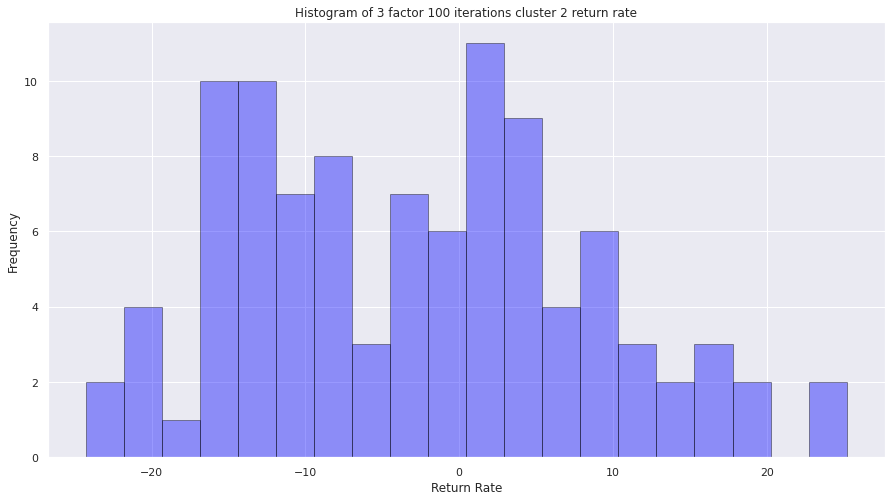

In [ ]:
sns.distplot(return_list_3_factor_100_iteration_cluster_2, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('Histogram of 3 factor 100 iterations cluster 2 return rate')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.savefig('3_factor_100_iteration_cluster_2_return_rate_histogram.png')

This is the end. Hope you enjoy it.